# Joining all datasets with generalized column names

- With hate not included
- What is thumbs up supposed to mean in by_fans page
- Random is included but party will be random
- 0:Unbiased, 1: far-left, 2:centre-left, 3:centre, 4: centre-right, 5:far-right
- Type signifies each page in polly dataset
    - Type 5 is hate and is not included because it does not have party information


In [148]:
import pandas as pd
import glob
import re

In [149]:
RAW_DATA_PATH = '../data/polly/raw/'

In [150]:
def preprocess(row):
    result = re.sub(r"http\S+", "", row['Tweet'])
    result = re.sub(r"RT @\S+", "", result)
    result = re.sub(r"@\S+", "", result)
    result = re.sub(r"\n", "", result)
    return result

In [5]:
data = pd.DataFrame()

In [6]:
page = pd.read_csv(RAW_DATA_PATH + 'about_party.csv')
page = page.rename(columns={'♡': 'Likes'})
page = page.rename(columns={'About': 'Party'})
page['Type'] = 1
page = page[['Tweet', 'Likes', 'Party', 'Type']]
data = data.append(page, ignore_index=True)

In [7]:
page = pd.read_csv(RAW_DATA_PATH + 'by_party.csv')
page = page.rename(columns={'♡': 'Likes'})
page = page.rename(columns={'By': 'Party'})
page['Type'] = 2
page = page[['Tweet', 'Likes', 'Party', 'Type']]
data = data.append(page, ignore_index=True)

In [8]:
page = pd.read_csv(RAW_DATA_PATH + 'by_fans.csv')
page = page.rename(columns={'♡': 'Likes'})
page = page.rename(columns={'👍': 'Party'})
page['Type'] = 3
page = page[['Tweet', 'Likes', 'Party', 'Type']]
data = data.append(page, ignore_index=True)

In [9]:
page = pd.read_csv(RAW_DATA_PATH + 'with_emoji.csv')
page = page.rename(columns={'♡': 'Likes'})
page = page.rename(columns={'About': 'Party'})
page['Type'] = 4
page = page[['Tweet', 'Likes', 'Party', 'Type']]
data = data.append(page, ignore_index=True)

In [10]:
page = pd.read_csv(RAW_DATA_PATH + 'with_isa.csv')
page = page.rename(columns={'♡': 'Likes'})
page = page.rename(columns={'About': 'Party'})
page['Type'] = 6
page = page[['Tweet', 'Likes', 'Party', 'Type']]
data = data.append(page, ignore_index=True)

In [11]:
page = pd.read_csv(RAW_DATA_PATH + 'random.csv')
page = page.rename(columns={'♡': 'Likes'})
# page = page.rename(columns={'👍': 'Party'})
page['Type'] = 7
page['Party'] = 'random'
page = page[['Tweet', 'Likes', 'Party', 'Type']]
data = data.append(page, ignore_index=True)

In [12]:
data['text'] = data.apply(preprocess,axis=1)

In [13]:
data.shape

(106048, 5)

In [14]:
data = data.dropna()

In [15]:
data = data[data['Party'].notnull()]
data = data[data['text'].notnull()]

## Reducing data to just to include two extremes

In [16]:
data = data[data['Party'].isin(['AfD','Die Linke'])]
data = data[data['Party'].notnull()]
data['labels'] = 0
data.loc[data.Party == 'Die Linke', ['labels']] = 0
data.loc[data.Party == 'AfD', ['labels']] = 1
# data = data.rename(columns={'Label':'labels'})

In [17]:
data.to_csv('../data/polly/polly.csv')

In [18]:
data = pd.read_csv('../data/polly/polly.csv')
del data['Unnamed: 0']

In [19]:
data_0 = data[data['Party']=='Die Linke']
data_1 = data[data['Party']=='AfD']
data_1 = data_1.sample(data_0.shape[0])

In [20]:
print(data_0.shape)
print(data_1.shape)

(8185, 6)
(8185, 6)


In [21]:
train= pd.DataFrame()
train = train.append(data_0.sample(frac=0.9))
test = pd.DataFrame()
test= test.append(data_0.drop(train.index))
train = train.append(data_1.sample(frac=0.9))
test= test.append(data_1.drop(train[train['Party']=='AfD'].index))

train.to_csv('../data/polly/polly_train1.csv')
test.to_csv('../data/polly/polly_test1.csv')

In [22]:
print(train[train['Party'] == 'AfD'].shape)
print(train[train['Party'] == 'Die Linke'].shape)

(7366, 6)
(7366, 6)


In [28]:
train = train.dropna()
train.to_csv('../data/polly/polly_train1.csv')

In [29]:
print(test.shape)
test = test.dropna()
print(test.shape)
test.to_csv('../data/polly/polly_test1.csv')

(1638, 6)
(1638, 6)


In [99]:
train = pd.read_csv('../data/polly/polly_train.csv')
train.shape


(17031, 7)

In [31]:
train.shape


(14725, 6)

## Test results on binary data

### For model v2 for unbalanced classes

In [98]:
train = pd.read_csv('../data/polly/polly_train_gbert_large.csv')
test = pd.read_csv('../data/polly/polly_test_gbert_large.csv')

In [143]:
predicted = pd.read_csv('../data/polly/polly_test_bert_base_predicted_16.csv')

In [144]:
s = predicted[predicted['labels'] == predicted['prediction']]

In [145]:
accuracy = (s.shape)[0]/(predicted.shape)[0]
print(accuracy)

0.8144078144078144


In [146]:
intermediate = predicted[predicted['labels'] == 1]
tp = (intermediate[intermediate['prediction']==1].shape)[0]
fn = intermediate[intermediate['prediction']==0].shape[0]
intermediate = predicted[predicted['labels'] == 0]
tn = intermediate[intermediate['prediction']==0].shape[0]
fp = intermediate[intermediate['prediction']==1].shape[0]
print(tp,tn,fp,fn)

668 666 153 151


In [147]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2*((precision*recall)/(precision+recall))
print(accuracy,precision,recall,f1_score)

0.8144078144078144 0.8136419001218027 0.8156288156288156 0.8146341463414635


In [ ]:
# train with preprocessing
# learns party specific may not be based on the semantics
# Try zero shot with available models
# Use the model with other parties to see threshold based agreement

## Other parties data

In [17]:
data = data[data['Party'].notnull()]
data = data[data['text'].notnull()]

In [ ]:
del data['labels']

# predicition on different parties

In [18]:
data = data[data['Party'].isin(['FDP','CDU','Die Grünen','SPD','CSU','random'])]
data = data[data['Party'].notnull()]
data['label'] = 0
data['text'] = data.apply(preprocess,axis=1)

In [19]:
data['Party'].unique()

array(['FDP', 'CDU', 'Die Grünen', 'SPD', 'CSU', 'random'], dtype=object)

In [86]:
data.to_csv('../data/polly/other_parties.csv')

In [21]:
predicted = pd.read_csv('../data/polly/other_parties_predicted.csv')

In [22]:
import numpy as np
p = predicted[predicted['Party']=='random']
p_right = p[p['prediction']==1]
print('Percentage right : ', p_right.shape[0]/ p.shape[0])
p_left = p[p['prediction']==0]
print('mean probability for right: ',np.mean(np.array(p_right['probabilities'].tolist())))
print('std: ',np.std(np.array(p_right['probabilities'].tolist())))
print('median: ', np.median(np.array(p_right['probabilities'].tolist())))
print('Mean probability for left: ',np.mean(np.array(p_left['probabilities'].tolist())))

Percentage right :  0.46818067332717656
mean probability for right:  0.9557483476779284
std:  0.09982604482581645
median:  0.9978795051574708
Mean probability for left:  0.03745034753988003


FDP :
Percentage right :  0.5189061886693707
mean probability for right:  0.9631497984544473
std:  0.08861969671054513
median:  0.998441219329834
CDU :
Percentage right :  0.5558645347104976
mean probability for right:  0.970054559927445
std:  0.08430349321980597
median:  0.999220848083496
Mean probability for left: 0.03478617466948551
Die Grünen : 
Percentage right :  0.5072124756335282
mean probability for right:  0.9637299863888367
std:  0.09324209251693516
median:  0.9986621141433716
Mean probability for left:  0.03821723985493388
SPD : 
Percentage right :  0.5511957278848386
mean probability for right:  0.9657167397947902
std:  0.08788509247678603
median:  0.998898983001709
Mean probability for left:  0.03519495763810857
CSU :
Percentage right :  0.6351125938281902
mean probability for right:  0.9697873348165952
std:  0.08227020757262209
median:  0.9990532994270324
Mean probability for left:  0.04239499288147112
random :
Percentage right :  0.46818067332717656
mean probability for right:  0.9557483476779284
std:  0.09982604482581645
median:  0.9978795051574708
Mean probability for left:  0.03745034753988003

In [89]:
p.head()

Unnamed: 0  Unnamed: 0.1  \
0           0             0   
1           1             1   
2           2             2   
3           3             3   
4           4             4   

                                                                                                                               Tweet  \
0                "Die FDP ist noch nicht über den Berg und sollte Demut bewahren", mahnt der Parteigrande Hermann-Otto Solms http://   
1  Solms warnt FDP nach Dreikönigstreffen vor zu viel Hochmut: Der FDP-Bundesschatzmeister Hermann-Otto Solms (FDP)… http:// http://   
2                                                                              Da hat Marco Buschmann vollkommen recht... cv http://   
3                                                                    Live vom Neujahrsempfang der FDP mit Hermann Otto Solms http://   
4                                                                 Leser 2017: Marco Buschmann, Bundesgeschäftsführer der FDP http://   

   Likes Party  Type  \
0      0   FDP     1   
1      0   FDP     1   
2      0   FDP     1   
3      0   FDP     1   
4      0   FDP     1   

                                                                                                                  text  \
0         "Die FDP ist noch nicht über den Berg und sollte Demut bewahren", mahnt der Parteigrande Hermann-Otto Solms    
1  Solms warnt FDP nach Dreikönigstreffen vor zu viel Hochmut: Der FDP-Bundesschatzmeister Hermann-Otto Solms (FDP)…     
2                                                                       Da hat Marco Buschmann vollkommen recht... cv    
3                                                             Live vom Neujahrsempfang der FDP mit Hermann Otto Solms    
4                                                          Leser 2017: Marco Buschmann, Bundesgeschäftsführer der FDP    

   label  prediction  probabilities  
0      0           1       0.991131  
1      0           1       0.999892  
2      0           0       0.000933  
3      0           1       0.968151  
4      0           0       0.000313

# Analysing the failures using v2 so as to identify patterns

In [83]:
test_predicted = pd.read_csv('../data/polly/polly_test_bert_base_predicted_v1.csv')

In [84]:
test_predicted.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Tweet', 'Likes', 'Party', 'Type', 'text',
       'labels', 'prediction', 'probabilities'],
      dtype='object')

In [85]:
wrong_predictions = pd.DataFrame()
intermediate = test_predicted[test_predicted['Party']=='AfD']
intermediate = intermediate[intermediate['prediction']==0]
print(intermediate.shape)
wrong_predictions = wrong_predictions.append(intermediate, ignore_index=True)
intermediate = test_predicted[test_predicted['Party']=='Die Linke']
intermediate = intermediate[intermediate['prediction']==1]
print(intermediate.shape)
wrong_predictions = wrong_predictions.append(intermediate, ignore_index=True)

(141, 10)
(135, 10)


In [ ]:
from deep_translator import GoogleTranslator
def translate_to_english(row):
    if (not len(row['text'])>5000):
        if(len(row['text'].strip())>0):
            print('---------------------',row['text'])
            english_text = GoogleTranslator(source='de', target='en').translate(row['text'])
    #         print(english_text)
            return english_text
    else:
        return None
wrong_predictions['english_text'] = wrong_predictions.apply(translate_to_english, axis=1)

In [191]:
wrong_predictions.to_csv('../results/wrong_predictions_v2_to_analyse.csv')

In [89]:
correct_predictions = pd.DataFrame()
intermediate = test_predicted[test_predicted['Party']=='AfD']
intermediate = intermediate[intermediate['prediction']==1]
print(intermediate.shape)
correct_predictions = correct_predictions.append(intermediate, ignore_index=True)
intermediate = test_predicted[test_predicted['Party']=='Die Linke']
intermediate = intermediate[intermediate['prediction']==0]
print(intermediate.shape)
correct_predictions = correct_predictions.append(intermediate, ignore_index=True)

(677, 10)
(684, 10)


In [ ]:
correct_predictions['english_text'] = correct_predictions.apply(translate_to_english, axis=1)
correct_predictions.to_csv('../results/correct_predictions_v2_to_analyse.csv')

## Analysis of words based on the PMI score

In [94]:
from collections import Counter
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import font_manager
from sklearn.feature_extraction.text import CountVectorizer
from collections import OrderedDict
from nltk.corpus import stopwords

In [95]:
german_stop_words = stopwords.words('german')

def get_top_n_features_based_pmi(n, left_tweets, right_tweets, left=True):
    n_left = len(left_tweets)
    n_right = len(right_tweets)
    left_document = ' '.join(left_tweets)
    right_document = ' '.join(right_tweets)
    document = ' '.join([left_document,right_document])
    cv = CountVectorizer(stop_words=german_stop_words)
    cv_fit = cv.fit_transform([left_document, right_document])
    features = cv.get_feature_names()
    
    counts = cv_fit.toarray()
    print(len(features), counts.shape)
    pmi = []
    for index, f in enumerate(features):
        N = (n_left + n_right)
        p_x = (counts[0][index]+counts[1][index])/N
        p_x_left = counts[0][index]/N
        p_x_right = counts[1][index]/N
        p_left = n_left/N
        p_right = n_right/N
        
        try:
            pmi_x_left = math.log2(p_x_left/(p_x * p_left))
        except ZeroDivisionError:
            pmi_x_left = 0
        except Exception as e:
            pmi_x_left = 0
        try:
            pmi_x_right = math.log2(p_x_right/(p_x * p_right))
        except ZeroDivisionError:
            pmi_x_right = 0
        except Exception as e:
            pmi_x_right = 0
        
        combined_score = (pmi_x_left - pmi_x_right)
        if left:
            combined_score = (pmi_x_left - pmi_x_right) * p_x_left
        else:
            combined_score = (pmi_x_right - pmi_x_left) * p_x_right
            
        pmi.append({'feature':f,
                    'pmi_left': pmi_x_left,
                    'pmi_right': pmi_x_right,
                    'score': combined_score})
    
    pmi_df = pd.DataFrame(pmi)
    pmi_df = pmi_df.sort_values(by=['score'], ascending=False)
    print('left: ', left, pmi_df.tail(5))
    top_n = pmi_df.head(n)
    print('top_n: ', top_n)
    return top_n

In [ ]:

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(wrong_predictions.shape)
wrong_predictions = wrong_predictions.dropna()
print(wrong_predictions.shape)
top_n_left = get_top_n_features_based_pmi(100,
                             wrong_predictions[wrong_predictions['labels']==0]['text'].tolist(),
                             wrong_predictions[wrong_predictions['labels']==1]['text'].tolist(),
                            left=True)
top_n_right = get_top_n_features_based_pmi(100,
                             wrong_predictions[wrong_predictions['labels']==0]['text'].tolist(),
                             wrong_predictions[wrong_predictions['labels']==1]['text'].tolist(),
                            left=False)

In [97]:
top_n_left.to_csv('../results/top_n_left_wrong_predictions.csv')
top_n_right.to_csv('../results/top_n_right_wrong_predictions.csv')

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(correct_predictions.shape)
correct_predictions = correct_predictions.dropna()
print(correct_predictions.shape)
top_n_left = get_top_n_features_based_pmi(100,
                             correct_predictions[correct_predictions['labels']==0]['text'].tolist(),
                             correct_predictions[correct_predictions['labels']==1]['text'].tolist(),
                            left=True)
top_n_right = get_top_n_features_based_pmi(100,
                             correct_predictions[correct_predictions['labels']==0]['text'].tolist(),
                             correct_predictions[correct_predictions['labels']==1]['text'].tolist(),
                            left=False)

In [142]:
top_n_left.to_csv('../results/top_n_left_correct_predictions.csv')
top_n_right.to_csv('../results/top_n_right_correct_predictions.csv')

## Ablation study


In [151]:
data = pd.DataFrame()
page = pd.read_csv(RAW_DATA_PATH + 'by_party.csv')
page = page.rename(columns={'♡': 'Likes'})
page = page.rename(columns={'By': 'Party'})
page['Type'] = 2
page = page[['Tweet', 'Likes', 'Party', 'Type']]
data = data.append(page, ignore_index=True)


In [172]:
data['text'] = data.apply(preprocess,axis=1)
data = data.dropna()
data = data[data['Party'].notnull()]
data = data[data['text'].notnull()]


In [173]:
data = data[data['Party'].isin(['AfD','Die Linke'])]
data = data[data['Party'].notnull()]
data['labels'] = 0
data.loc[data.Party == 'Die Linke', ['labels']] = 0
data.loc[data.Party == 'AfD', ['labels']] = 1

In [157]:
data.to_csv('../data/polly/polly_by_party.csv')

In [183]:
data = pd.DataFrame()
page = pd.read_csv(RAW_DATA_PATH + 'by_fans.csv')
page = page.rename(columns={'♡': 'Likes'})
page = page.rename(columns={'👍': 'Party'})
page['Type'] = 3
page = page[['Tweet', 'Likes', 'Party', 'Type']]
data = data.append(page, ignore_index=True)
data['text'] = data.apply(preprocess,axis=1)
data = data.dropna()
data = data[data['Party'].notnull()]
data = data[data['text'].notnull()]
data = data[data['Party'].isin(['AfD','Die Linke'])]
data = data[data['Party'].notnull()]
data['labels'] = 0
data.loc[data.Party == 'Die Linke', ['labels']] = 0
data.loc[data.Party == 'AfD', ['labels']] = 1
data_0 = data[data['Party']=='Die Linke']
print(data_0.shape)
data_1 = data[data['Party']=='AfD']
print(data_1.shape)
data_1 = data_1.sample(data_0.shape[0])
data = data_0.append(data_1,ignore_index=True)
print(data.shape, data.head())

(3189, 6)
(5387, 6)
(6378, 6)                                                Tweet  Likes      Party  Type                                               text  labels
0  @name @name Könnte man dann erklären, was an d...      3  Die Linke     3    Könnte man dann erklären, was an der jetzige...       0
1  @name @name @name Korrekt. \nDie sind alle dur...      0  Die Linke     3     Korrekt. Die sind alle durch Kontrollen rei...       0
2  @name @name @polizei Die kostet ja den einzeln...      0  Die Linke     3     Die kostet ja den einzelnen Hauptschulabbre...       0
3  @name @name Außerdem fordere ich ungern etwas,...      0  Die Linke     3    Außerdem fordere ich ungern etwas, das ich n...       0
4  @name @name Das habe ich nicht gesagt. Einzeln...      3  Die Linke     3    Das habe ich nicht gesagt. Einzeln rausziehe...       0


In [184]:
by_party_train = pd.read_csv('../data/polly/polly_by_party_train_bert_base.csv')
del by_party_train['Unnamed: 0']
data = data.append(by_party_train, ignore_index=True)

In [189]:
data[data['Type']==3].shape

(6378, 6)

In [190]:
data.to_csv('../data/polly/polly_train_type23_balanced.csv')

In [192]:
predicted = pd.read_csv('../data/polly/polly_by_party_test_bert_base_predicted.csv')
s = predicted[predicted['labels'] == predicted['prediction']]
accuracy = (s.shape)[0]/(predicted.shape)[0]
print(accuracy)
intermediate = predicted[predicted['labels'] == 1]
tp = (intermediate[intermediate['prediction']==1].shape)[0]
fn = intermediate[intermediate['prediction']==0].shape[0]
intermediate = predicted[predicted['labels'] == 0]
tn = intermediate[intermediate['prediction']==0].shape[0]
fp = intermediate[intermediate['prediction']==1].shape[0]
print(tp,tn,fp,fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2*((precision*recall)/(precision+recall))
print(accuracy,precision,recall,f1_score)

0.8702290076335878
162 180 17 34
0.8702290076335878 0.9050279329608939 0.826530612244898 0.864


In [193]:
predicted = pd.read_csv('../data/polly/polly_by_party_by_fans_test_bert_base_predicted.csv')
s = predicted[predicted['labels'] == predicted['prediction']]
accuracy = (s.shape)[0]/(predicted.shape)[0]
print(accuracy)
intermediate = predicted[predicted['labels'] == 1]
tp = (intermediate[intermediate['prediction']==1].shape)[0]
fn = intermediate[intermediate['prediction']==0].shape[0]
intermediate = predicted[predicted['labels'] == 0]
tn = intermediate[intermediate['prediction']==0].shape[0]
fp = intermediate[intermediate['prediction']==1].shape[0]
print(tp,tn,fp,fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2*((precision*recall)/(precision+recall))
print(accuracy,precision,recall,f1_score)

0.8600508905852418
161 177 20 35
0.8600508905852418 0.8895027624309392 0.8214285714285714 0.8541114058355436


In [199]:
predicted = pd.read_csv('../data/polly/polly_by_party_by_fans_balanced_test_bert_base_predicted.csv')
s = predicted[predicted['labels'] == predicted['prediction']]
accuracy = (s.shape)[0]/(predicted.shape)[0]
print(accuracy)
intermediate = predicted[predicted['labels'] == 1]
tp = (intermediate[intermediate['prediction']==1].shape)[0]
fn = intermediate[intermediate['prediction']==0].shape[0]
intermediate = predicted[predicted['labels'] == 0]
tn = intermediate[intermediate['prediction']==0].shape[0]
fp = intermediate[intermediate['prediction']==1].shape[0]
print(tp,tn,fp,fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2*((precision*recall)/(precision+recall))
print(accuracy,precision,recall,f1_score)

0.8498727735368957
154 180 17 42
0.8498727735368957 0.9005847953216374 0.7857142857142857 0.8392370572207084


## Classification models along two different dimensions

In [1172]:
data = pd.DataFrame()
page = pd.read_csv(RAW_DATA_PATH + 'by_party.csv')
page = page.rename(columns={'♡': 'Likes'})
page = page.rename(columns={'By': 'Party'})
page['Type'] = 2
page = page[['Tweet', 'Likes', 'Party', 'Type']]
data = data.append(page, ignore_index=True)
data['text'] = data.apply(preprocess,axis=1)
data = data.dropna()
data = data[data['Party'].notnull()]
data = data[data['text'].notnull()]

In [1169]:
data['Party'].unique()

array(['CSU', 'AfD', 'FDP', 'Die Grünen', 'Die Linke', 'CDU', 'SPD'],
      dtype=object)

In [1170]:
data = data[data['Party'].isin(['AfD','Die Grünen'])]
data = data[data['Party'].notnull()]
data['labels'] = 0
data.loc[data.Party == 'Die Grünen', ['labels']] = 0
data.loc[data.Party == 'AfD', ['labels']] = 1
# data.to_csv('../data/polly/polly_by_party_afd_greens.csv')

In [206]:
data_0 = data[data['Party']=='Die Grünen']
data_1 = data[data['Party']=='AfD']
# data_1 = data_1.sample(data_0.shape[0])
print(data_0.shape, data_1.shape)

(2161, 6) (2404, 6)


In [216]:
predicted = pd.read_csv('../data/polly/polly_test_afd_green_bert_base_predicted.csv')
s = predicted[predicted['labels'] == predicted['prediction']]
accuracy = (s.shape)[0]/(predicted.shape)[0]
print(accuracy)
intermediate = predicted[predicted['labels'] == 1]
tp = (intermediate[intermediate['prediction']==1].shape)[0]
fn = intermediate[intermediate['prediction']==0].shape[0]
intermediate = predicted[predicted['labels'] == 0]
tn = intermediate[intermediate['prediction']==0].shape[0]
fp = intermediate[intermediate['prediction']==1].shape[0]
print(tp,tn,fp,fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2*((precision*recall)/(precision+recall))
print(accuracy,precision,recall,f1_score)

0.9236111111111112
199 200 16 17
0.9236111111111112 0.9255813953488372 0.9212962962962963 0.9234338747099768


In [217]:
predicted.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Tweet', 'Likes', 'Party', 'Type', 'text', 'labels', 'prediction', 'probabilities'], dtype='object')

In [215]:
predicted = pd.read_csv('../data/polly/polly_test_fdp_linke_bert_base_predicted.csv')
s = predicted[predicted['labels'] == predicted['prediction']]
accuracy = (s.shape)[0]/(predicted.shape)[0]
print(accuracy)
intermediate = predicted[predicted['labels'] == 1]
tp = (intermediate[intermediate['prediction']==1].shape)[0]
fn = intermediate[intermediate['prediction']==0].shape[0]
intermediate = predicted[predicted['labels'] == 0]
tn = intermediate[intermediate['prediction']==0].shape[0]
fp = intermediate[intermediate['prediction']==1].shape[0]
print(tp,tn,fp,fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2*((precision*recall)/(precision+recall))
print(accuracy,precision,recall,f1_score)

0.8629441624365483
163 177 20 34
0.8629441624365483 0.8907103825136612 0.8274111675126904 0.8578947368421053


In [1173]:
data = pd.DataFrame()
page = pd.read_csv(RAW_DATA_PATH + 'by_party.csv')
page = page.rename(columns={'♡': 'Likes'})
page = page.rename(columns={'By': 'Party'})
page['Type'] = 2
page = page[['Tweet', 'Likes', 'Party', 'Type']]
data = data.append(page, ignore_index=True)
data['text'] = data.apply(preprocess,axis=1)
data = data.dropna()
data = data[data['Party'].notnull()]
data = data[data['text'].notnull()]

In [1174]:
data = data[data['Party'].isin(['FDP','Die Linke'])]
data = data[data['Party'].notnull()]
data['labels'] = 0
data.loc[data.Party == 'Die Linke', ['labels']] = 0
data.loc[data.Party == 'FDP', ['labels']] = 1
# data.to_csv('../data/polly/polly_by_party_fdp_linke.csv')

In [1175]:
data.shape

(4484, 6)

In [210]:
data_0 = data[data['Party']=='Die Linke']
data_1 = data[data['Party']=='FDP']
# data_1 = data_1.sample(data_0.shape[0])
print(data_0.shape, data_1.shape)

(1965, 6) (2519, 6)


### Prediction of these two models on other parties and visualizing their scatter plots


In [222]:
data = pd.DataFrame()
page = pd.read_csv(RAW_DATA_PATH + 'by_party.csv')
page = page.rename(columns={'♡': 'Likes'})
page = page.rename(columns={'By': 'Party'})
page['Type'] = 2
page = page[['Tweet', 'Likes', 'Party', 'Type']]
data = data.append(page, ignore_index=True)
data['text'] = data.apply(preprocess,axis=1)
data = data.dropna()
data = data[data['Party'].notnull()]
data = data[data['text'].notnull()]
data = data[data['Party'].isin(['FDP','CDU','Die Linke','SPD','CSU','random'])]
data = data[data['Party'].notnull()]
data.to_csv('../data/polly/other_parties_afd_greens.csv')

In [223]:
data = pd.DataFrame()
page = pd.read_csv(RAW_DATA_PATH + 'by_party.csv')
page = page.rename(columns={'♡': 'Likes'})
page = page.rename(columns={'By': 'Party'})
page['Type'] = 2
page = page[['Tweet', 'Likes', 'Party', 'Type']]
data = data.append(page, ignore_index=True)
data['text'] = data.apply(preprocess,axis=1)
data = data.dropna()
data = data[data['Party'].notnull()]
data = data[data['text'].notnull()]
data = data[data['Party'].isin(['AfD','CDU','Die Grünen','SPD','CSU','random'])]
data = data[data['Party'].notnull()]
data.to_csv('../data/polly/other_parties_fdp_linke.csv')

In [220]:
def get_probability_for_class1(row):
    if row['prediction'] ==1:
        return row['probabilities']
    else:
        return 1 - row['probabilities']

Text(0, 0.5, 'Predictions')

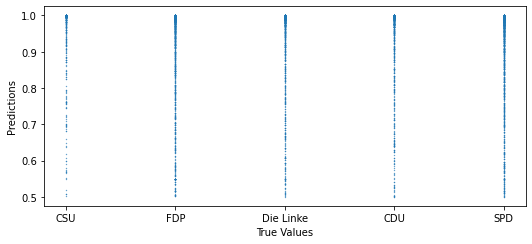

In [242]:
import matplotlib.pyplot as plt 
predicted = pd.read_csv('../data/polly/other_parties_afd_greens_predicted.csv')
predicted['class_1_probabilities'] = predicted.apply(get_probability_for_class1, axis=1)
# plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(predicted['Party'], predicted['class_1_probabilities'],s=0.1)
plt.xlabel('True Values')
plt.ylabel('Predictions')





(5167, 9)
(5167, 9)


Text(0.5, 1.0, 'Probabilty of tweet belonging to right wing')

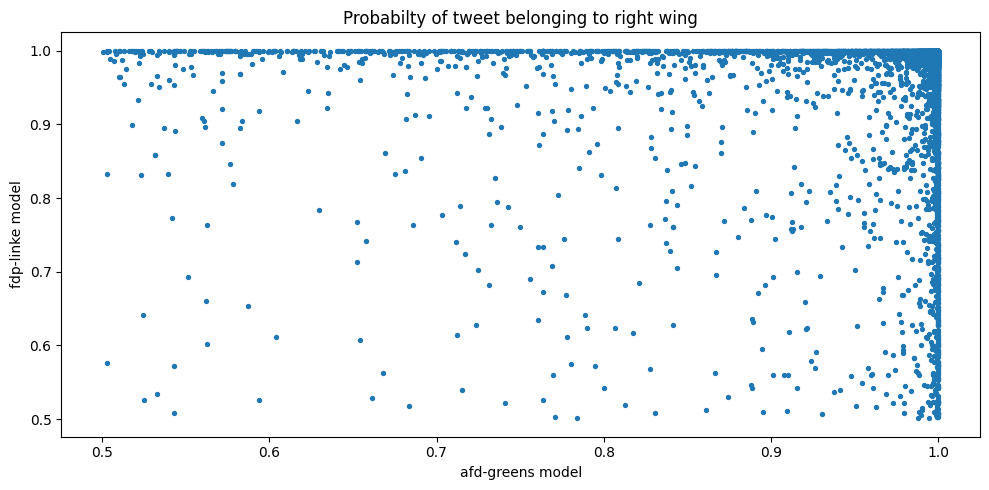

In [263]:
import matplotlib.pyplot as plt 
predicted_linke = pd.read_csv('../data/polly/other_parties_fdp_linke_predicted.csv')
predicted_linke = predicted_linke[predicted_linke['Party'].isin(['CSU', 'CDU', 'SPD'])]
print(predicted_linke.shape)
predicted_greens = pd.read_csv('../data/polly/other_parties_afd_greens_predicted.csv')
predicted_greens = predicted_greens[predicted_greens['Party'].isin(['CSU', 'CDU', 'SPD'])]
print(predicted_greens.shape)
predicted_linke['class_1_probabilities'] = predicted.apply(get_probability_for_class1, axis=1)
predicted_greens['class_1_probabilities'] = predicted.apply(get_probability_for_class1, axis=1)

plt.figure(figsize=(10, 5), dpi =100)
plt.scatter(predicted_greens['class_1_probabilities'], predicted_linke['class_1_probabilities'], s = 8.0)
plt.xlabel('afd-greens model')
plt.ylabel('fdp-linke model')
plt.title('Probabilty of tweet belonging to right wing')


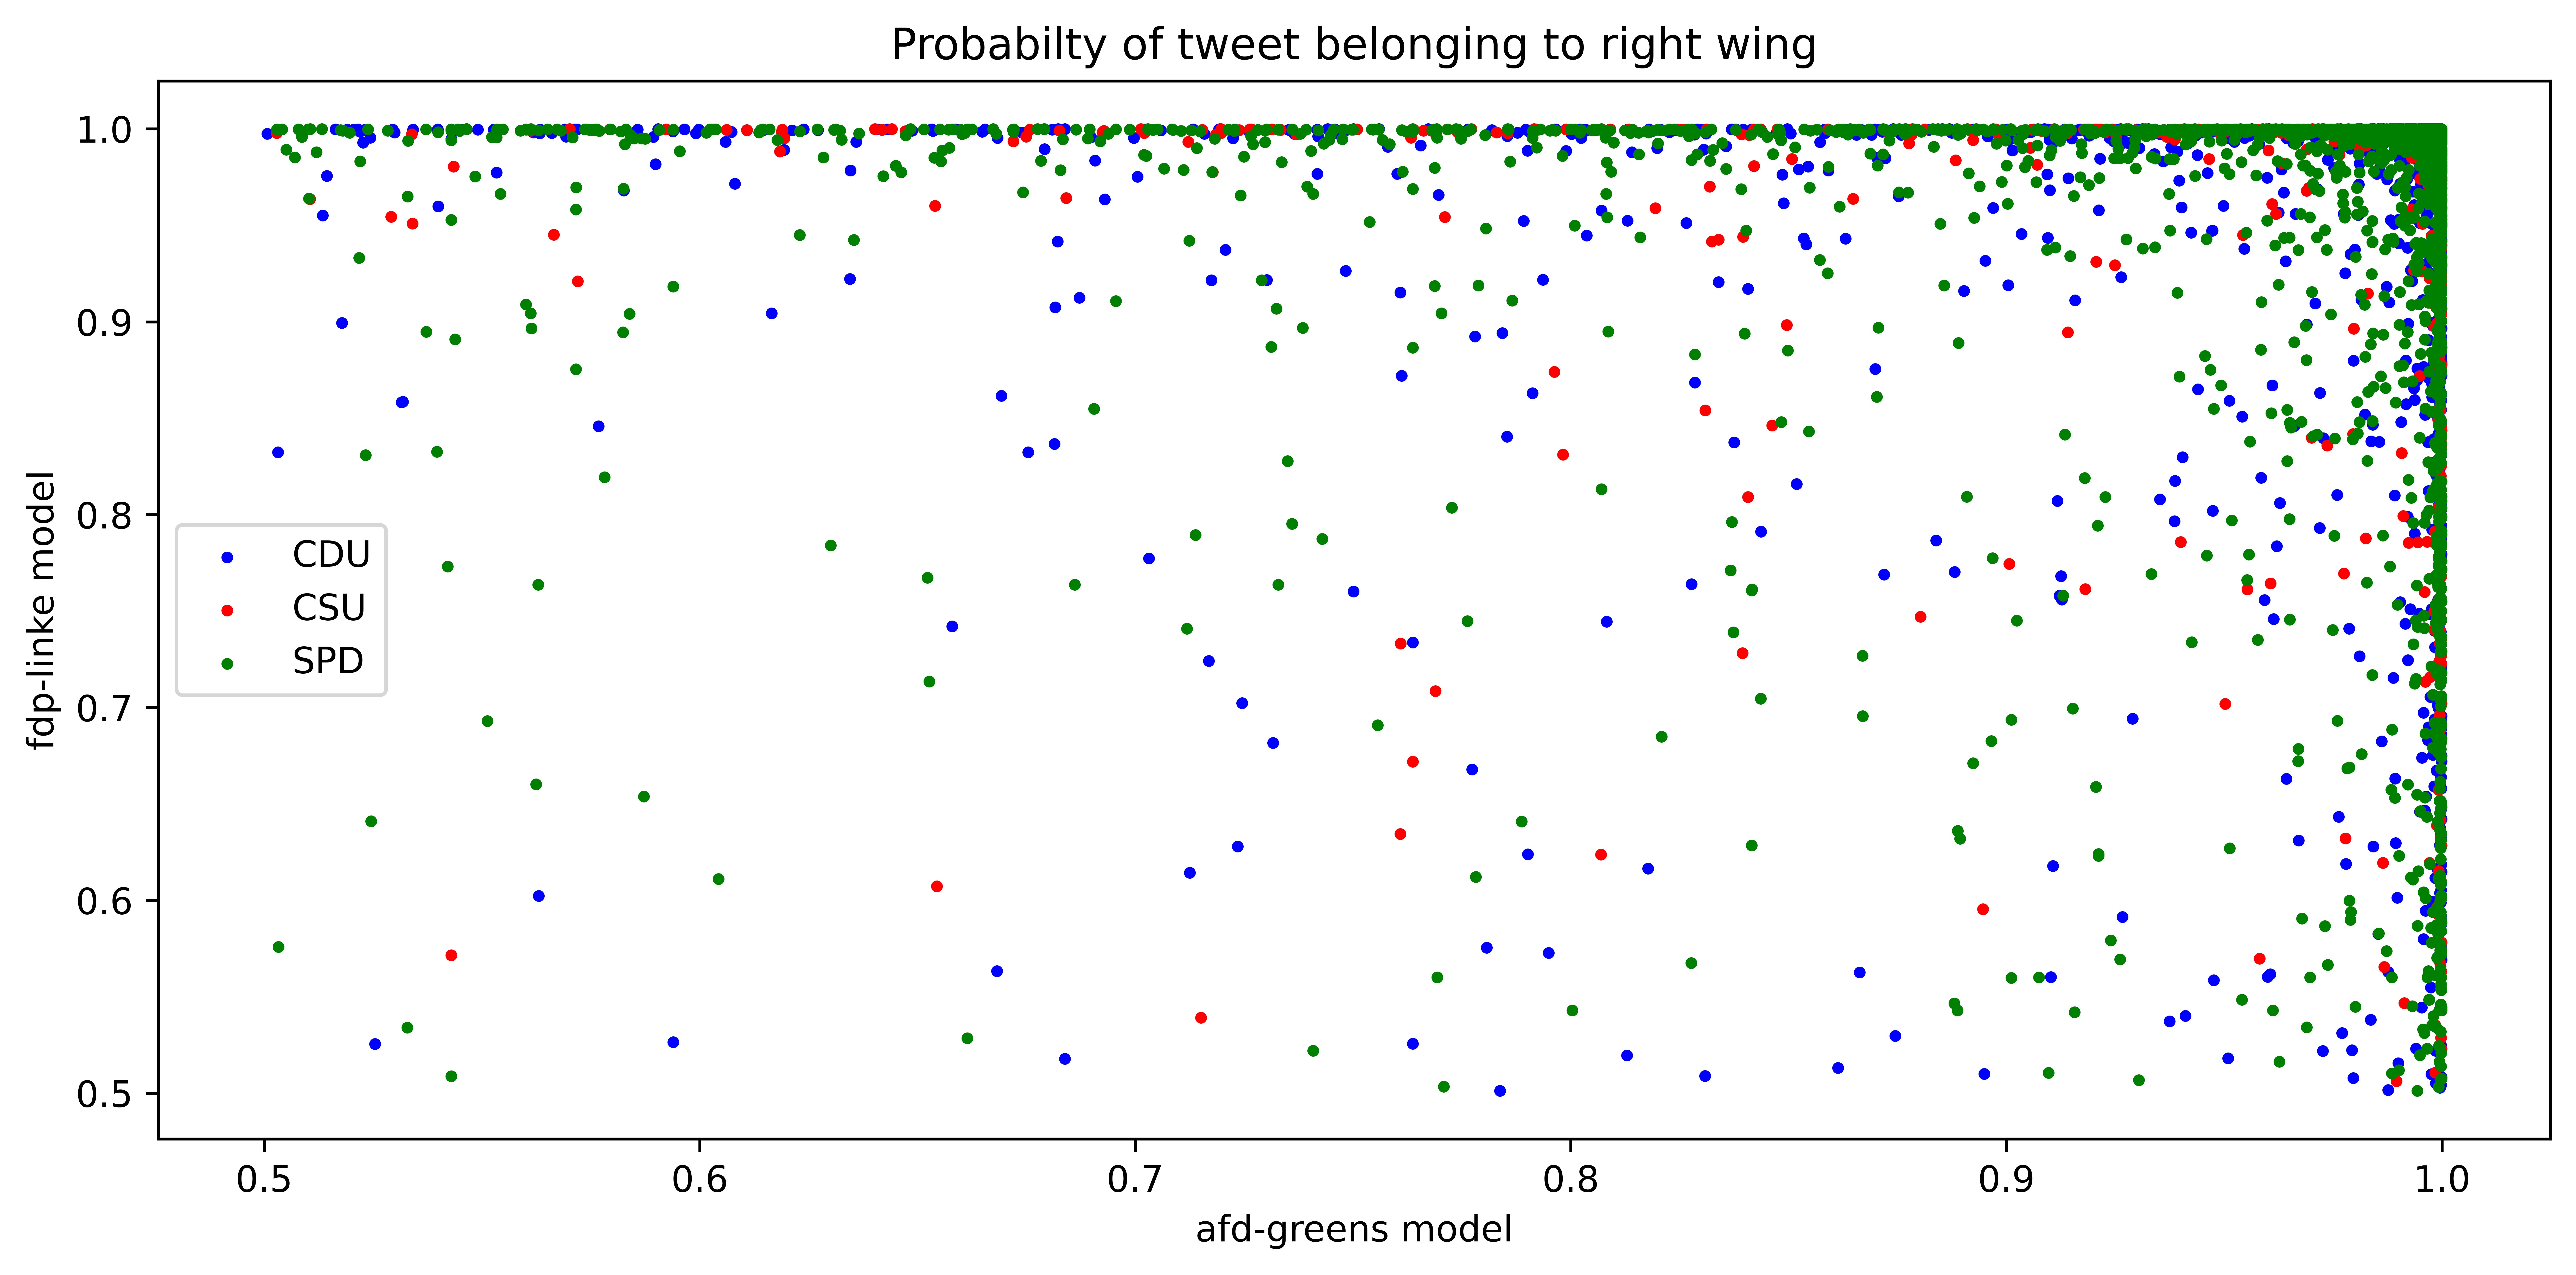

In [277]:
import numpy as np
from matplotlib import pyplot as plt

scatter_x = np.array(predicted_greens['class_1_probabilities'].tolist())
scatter_y = np.array(predicted_linke['class_1_probabilities'].tolist())
group = np.array(predicted_greens['Party'].tolist())
cdict = {'CSU': 'red', 'CDU': 'blue', 'SPD': 'green'}

fig, ax = plt.subplots(figsize=(10,5), dpi=1000)
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 5)
ax.set_xlabel('afd-greens model')
ax.set_ylabel('fdp-linke model')
ax.set_title('Probabilty of tweet belonging to right wing')
ax.legend()

In [250]:
predicted_linke.tail()

Unnamed: 0  Unnamed: 0.1                                              Tweet  Likes Party  Type                                               text  prediction  probabilities  class_1_probabilities
9605        9605         14083  Mit der Bayernhymne, dem Deutschlandlied und d...     12   CSU     2  Mit der Bayernhymne, dem Deutschlandlied und d...           0       0.001045               0.998955
9606        9606         14084  .@AndiScheuer zieht Bilanz: Das war ein sehr e...      6   CSU     2  . zieht Bilanz: Das war ein sehr erfolgreicher...           0       0.000434               0.999566
9608        9608         14088  Den kompletten #CSUPT17 zum nachlesen, gibt es...      5   CSU     2  Den kompletten #CSUPT17 zum nachlesen, gibt es...           0       0.165368               0.834632
9609        9609         14089  @Oliver_Krischer Leider überzeugen Erneuerbare...      8   CDU     2   Leider überzeugen Erneuerbare Belgien bisher ...           0       0.000138               0.999862
9612        9612         14096  @HartmutNeubauer @Oliver_Krischer @BaerbelHoeh...      0   CDU     2     Die beiden grünen Minister haben in eigener...           0       0.000515               0.999485

In [251]:
predicted_greens.tail()

Unnamed: 0  Unnamed: 0.1                                              Tweet  Likes Party  Type                                               text  prediction  probabilities  class_1_probabilities
9640        9640         14083  Mit der Bayernhymne, dem Deutschlandlied und d...     12   CSU     2  Mit der Bayernhymne, dem Deutschlandlied und d...           0       0.012605               0.999756
9641        9641         14084  .@AndiScheuer zieht Bilanz: Das war ein sehr e...      6   CSU     2  . zieht Bilanz: Das war ein sehr erfolgreicher...           0       0.237251               0.999849
9644        9644         14088  Den kompletten #CSUPT17 zum nachlesen, gibt es...      5   CSU     2  Den kompletten #CSUPT17 zum nachlesen, gibt es...           1       0.996933               0.999865
9645        9645         14089  @Oliver_Krischer Leider überzeugen Erneuerbare...      8   CDU     2   Leider überzeugen Erneuerbare Belgien bisher ...           0       0.000144               0.988072
9650        9650         14096  @HartmutNeubauer @Oliver_Krischer @BaerbelHoeh...      0   CDU     2     Die beiden grünen Minister haben in eigener...           0       0.000214               0.958632

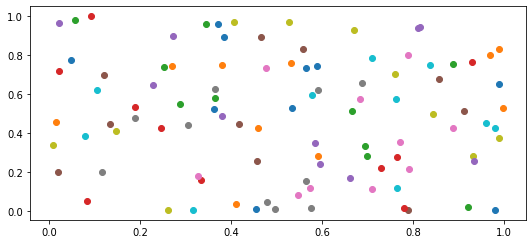

In [235]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
xs = np.random.rand(100)
ys = np.random.rand(100)
for x, y in zip(xs, ys):
    plt.scatter(x, y, cmap="copper")
plt.show()

In [ ]:
k = pd.read_csv('../data/polly/polly_test_afd_green_bert_base_attributions.csv')
k

In [284]:
w = k[k['labels'] != k['prediction']]

In [ ]:
import ast

for i,r in w.iterrows():
    print(r['prediction'], r['attributions'])
    print()


# Analysing important words for afd-green

## PMI scores

In [ ]:
from collections import Counter
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import font_manager
from sklearn.feature_extraction.text import CountVectorizer
from collections import OrderedDict
from nltk.corpus import stopwords

german_stop_words = stopwords.words('german')

def get_top_n_features_based_pmi(n, left_tweets, right_tweets, left=True):
    n_left = len(left_tweets)
    n_right = len(right_tweets)
    left_document = ' '.join(left_tweets)
    right_document = ' '.join(right_tweets)
    document = ' '.join([left_document,right_document])
    cv = CountVectorizer(stop_words=german_stop_words)
    cv_fit = cv.fit_transform([left_document, right_document])
    features = cv.get_feature_names()
    
    counts = cv_fit.toarray()
    pmi = []
    for index, f in enumerate(features):
        N = (n_left + n_right)
        p_x = (counts[0][index]+counts[1][index])/N
        p_x_left = counts[0][index]/N
        p_x_right = counts[1][index]/N
        p_left = n_left/N
        p_right = n_right/N
        
        try:
            pmi_x_left = math.log2(p_x_left/(p_x * p_left))
        except ZeroDivisionError:
            pmi_x_left = 0
        except Exception as e:
            pmi_x_left = 0
        try:
            pmi_x_right = math.log2(p_x_right/(p_x * p_right))
        except ZeroDivisionError:
            pmi_x_right = 0
        except Exception as e:
            pmi_x_right = 0
        
        combined_score = (pmi_x_left - pmi_x_right)
        if left:
            combined_score = (pmi_x_left - pmi_x_right) * p_x_left
        else:
            combined_score = (pmi_x_right - pmi_x_left) * p_x_right
            
        pmi.append({'feature':f,
                    'pmi_left': pmi_x_left,
                    'pmi_right': pmi_x_right,
                    'score': combined_score})
    
    pmi_df = pd.DataFrame(pmi)
    pmi_df = pmi_df.sort_values(by=['score'], ascending=False)
    top_n = pmi_df.head(n)
    return top_n

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

train_data = pd.read_csv('../data/polly/polly_train_afd_green_bert_base.csv')
top_n_left = get_top_n_features_based_pmi(100,
                             train_data[train_data['labels']==0]['text'].tolist(),
                             train_data[train_data['labels']==1]['text'].tolist(),
                            left=True)
top_n_right = get_top_n_features_based_pmi(100,
                             train_data[train_data['labels']==0]['text'].tolist(),
                             train_data[train_data['labels']==1]['text'].tolist(),
                            left=False)
print("########################")
print(top_n_left)
print("########################")
print(top_n_right)
print("########################")

In [394]:
d = {'pmi_left':top_n_left, 'pmi_right': top_n_right,
     'attention_left':attention_tokens_left, 'attention_right':attention_tokens_right ,
    'tf_idf': s
}

# Attentions

In [366]:
train_data = pd.read_csv('../data/polly/polly_train_afd_green_bert_base_attentions.csv')

In [370]:
import ast

attention_tokens_left = []
for i,r in train_data[train_data['labels']==0].iterrows():
    a = r['average_across_layers']
    tokens = r['tokens']
    if isinstance(a, str):
        a = ast.literal_eval(a)
    a = np.asarray(a)
    index = np.where(a == np.amax(a))
    if isinstance(tokens,str):
        tokens = ast.literal_eval(tokens)
    tokens = ['cls'] + tokens + ['sep']
    token = tokens[index[0][0]-1]
    attention_tokens_left.append(token)

attention_tokens_right = []
for i,r in train_data[train_data['labels']==1].iterrows():
    a = r['average_across_layers']
    tokens = r['tokens']
    if isinstance(a, str):
        a = ast.literal_eval(a)
    a = np.asarray(a)
    index = np.where(a == np.amax(a))
    if isinstance(tokens,str):
        tokens = ast.literal_eval(tokens)
    tokens = ['cls'] + tokens + ['sep']
    token = tokens[index[0][0]-1]
    attention_tokens_right.append(token)

# TF - IDF scores

In [490]:
def get_top_n_features_given_list_of_hashtag_texts(n, hashtags_left, hashtags_right, left=True):
    left_document = ' '.join(hashtags_left)
    left_length = len(left_document.split())
    right_document = ' '.join(hashtags_right)
    right_length = len(right_document.split())
    cv = CountVectorizer(stop_words=german_stop_words)
    cv_fit = cv.fit_transform([left_document, right_document])
    features = cv.get_feature_names()
    counts = cv_fit.toarray()
    print(counts.shape)
    tfidf = TfidfVectorizer(stop_words=german_stop_words)
    
    x = tfidf.fit_transform([left_document, right_document])
    idfs = tfidf.idf_
    if left:
        scores = np.multiply(counts[0]/left_length, idfs)
        frequencies = counts[0]/len(hashtags_left)
        feature_score = []
        for i in range(len(features)):
            feature_score.append({'feature':features[i],'score': scores[i]})
        tfidf_df = pd.DataFrame(feature_score)
        tfidf_df = tfidf_df.sort_values(by=['score'], ascending=False)
        top_n = tfidf_df.head(n)
        return top_n
    else:
        scores = np.multiply(counts[1]/right_length, idfs)
        frequencies = counts[1]/len(hashtags_right)
        feature_score = []
        for i in range(len(features)):
            feature_score.append({'feature':features[i],'score': scores[i]})
        tfidf_df = pd.DataFrame(feature_score)
        tfidf_df = tfidf_df.sort_values(by=['score'], ascending=False)
        top_n = tfidf_df.head(n)
        return top_n

In [491]:
train_data = pd.read_csv('../data/polly/polly_train_afd_green_bert_base.csv')
print(len(train_data[train_data['labels']==0]['text'].tolist()),
      len(train_data[train_data['labels']==1]['text'].tolist()))
top_n_left_tfidf = get_top_n_features_given_list_of_hashtag_texts(300,
                            train_data[train_data['labels']==0]['text'].tolist(),
                             train_data[train_data['labels']==1]['text'].tolist())
top_n_right_tfidf = get_top_n_features_given_list_of_hashtag_texts(300,
                            train_data[train_data['labels']==0]['text'].tolist(),
                             train_data[train_data['labels']==1]['text'].tolist(), left=False)


1945 1938
(2, 11274)
(2, 11274)


In [ ]:
k = pd.read_csv('../data/polly/polly_train_afd_green_bert_base.csv')

In [398]:
k = pd.read_csv('../data/polly/polly_test_afd_green_bert_base_attentions.csv')

In [446]:
k = pd.read_csv('../data/polly/afd-green-train-vocabulary.csv')

In [333]:
pd.set_option('display.max_colwidth', None)

In [334]:
k = k[k['labels']==k['prediction']]

In [338]:
import ast

attention_tokens = []
for i,r in k.iterrows():
    a = r['average_across_layers']
    tokens = r['tokens']
    if isinstance(a, str):
        a = ast.literal_eval(a)
    a = np.asarray(a)
    index = np.where(a == np.amax(a))
    if isinstance(tokens,str):
        tokens = ast.literal_eval(tokens)
    tokens = ['cls'] + tokens + ['sep']
#     print(len(tokens),len(a))
    token = tokens[index[0][0]-1]
    attention_tokens.append(token)

In [344]:
k = pd.read_csv('../data/polly/polly_test_afd_green_bert_base_predicted.csv')

In [363]:
for i,r in k.iterrows():
    text = r['text']
    if text.strip() == '':
        print(r['Tweet'])
# k[k['text'].strip() == '']

https://t.co/BIN1tUpixk https://t.co/Pyqjh3unl8


In [ ]:
def get_top_n_features_given_list_of_hashtag_texts(n, hashtags_hate, hashtags_neutral):
    hate_document = ' '.join(hashtags_hate)
    hate_length = len(hate_document.split())
    neutral_document = ' '.join(hashtags_neutral)
    cv = CountVectorizer()
    cv_fit = cv.fit_transform([hate_document, neutral_document])
    features = cv.get_feature_names()
    counts = cv_fit.toarray()
    tfidf = TfidfVectorizer()
    
    x = tfidf.fit_transform([hate_document, neutral_document])
    idfs = tfidf.idf_
    scores = np.multiply(counts[0]/hate_length, idfs)
    frequencies = counts[0]/len(hashtags_hate)
    feature_score = []
    for i in range(len(features)):
        feature_score.append({'feature':features[i],'score': scores[i]})
    tfidf_df = pd.DataFrame(feature_score)
    tfidf_df = tfidf_df.sort_values(by=['score'], ascending=False)
    top_n = tfidf_df.head(n)
    return top_n

# Error Analysis

In [495]:
path_to_store_vocabulary = '../data/polly/afd-green-train-vocabulary.csv'
path_to_store_pmi_tfidf_vocabulary = '../data/polly/afd-green-train-pmi_tfidf.csv'
pmi_tf_vocabulary = pd.read_csv(path_to_store_pmi_tfidf_vocabulary)
attention_data = pd.read_csv(path_to_store_vocabulary)

In [521]:
pmi_tf_vocabulary

Unnamed: 0          tf_idf_left_keys  tf_idf_left_scores        tf_idf_right_keys  tf_idf_right_scores             pmi_left_keys  pmi_left_scores           pmi_right_keys  pmi_right_scores
0             0                darumgruen            0.006684                      afd             0.028397               klimaschutz         0.158548                      afd          0.982644
1             1                 darumgrün            0.006217      traudichdeutschland             0.008631             kohleausstieg         0.116270      traudichdeutschland          0.525338
2             2                     btw17            0.005920                    btw17             0.005111                     bdk17         0.074434                       dr          0.081963
3             3                       get            0.004581                   merkel             0.002979                sondierung         0.072607                    guten          0.046548
4             4                     heute            0.004057                     zeit             0.002945              sondierungen         0.067651                   merkel          0.038748
5             5                      mehr            0.003858                     mehr             0.002640                    umwelt         0.067170                  grenzen          0.037951
6             6                    katrin            0.003646                      wer             0.002166                   jamaika         0.062920                     zeit          0.035628
7             7                      geht            0.003359                     geht             0.002132                     klima         0.054769                    bitte          0.034874
8             8               klimaschutz            0.003126                      fdp             0.002132                      grün         0.052815        spitzenkandidatin          0.028852
9             9                   jamaika            0.003093                       eu             0.002065                   zukunft         0.051611                     prof          0.028685
10           10             kohleausstieg            0.002428                   morgen             0.002065                     innen         0.049590                       09          0.025295
11           11                   zukunft            0.002361                    guten             0.001895                     heute         0.040269                      cdu          0.023261
12           12                      grün            0.002228                       dr             0.001862                darumgruen         0.036732                  bereits          0.022288
13           13                      gibt            0.002195                      cdu             0.001828                 darumgrün         0.034163                bundestag          0.020963
14           14                    müssen            0.001962                      mal             0.001726             gerechtigkeit         0.028307                       gg          0.020896
15           15                        ja            0.001896                    heute             0.001692                      2020         0.026763                    staat          0.020811
16           16                     grüne            0.001862                   müssen             0.001692                 glyphosat         0.025236                    lesen          0.019630
17           17               deutschland            0.001862              deutschland             0.001658                       get         0.025173                  btw2017          0.019354
18           18                     danke            0.001829                       ja             0.001658               glückwunsch         0.023917                   ltwnds          0.016325
19           19              sondierungen            0.001829                     land             0.001625              schl

In [497]:
path_to_test_data = '../data/polly/polly_test_afd_green_bert_base_predicted.csv'
test_data = pd.read_csv(path_to_test_data)

In [519]:
def compute_combined_score(row, attentions, pmi_tf_vocabulary, left=True):
    text = row['text']
    print(text)
    words = text.split()
    scores = []
    if left:
        for w in words:
            print(w)
            score = 0
            try:
                selected = pmi_tf_vocabulary.loc[pmi_tf_vocabulary['tf_idf_right_keys'] == w]
                score = score + selected['tf_idf_right_scores']
            except Exception as e:
                print(repr(e))
            try:
                selected = pmi_tf_vocabulary.loc[pmi_tf_vocabulary['pmi_right_keys'] == w]
                score = score + selected['pmi_right_scores']
            except Exception as e:
                print(repr(e))
            scores.append({'feature': w, 'combined_score':score})         
    else:
        for w in words:
            score = 0
            try:
                selected = pmi_tf_vocabulary.loc[pmi_tf_vocabulary['tf_idf_left_keys'] == w]
                score = score + selected['tf_idf_left_scores']
            except Exception as e:
                print(repr(e))
            try:
                selected = pmi_tf_vocabulary.loc[pmi_tf_vocabulary['pmi_left_keys'] == w]
                score = score + selected['pmi_left_scores']
            except Exception as e:
                print(repr(e))
            scores.append({'feature': w, 'combined_score':score})
    return scores
    

In [520]:
wrong_predictions = test_data[test_data['labels']!=test_data['prediction']]
wrong_left = wrong_predictions[wrong_predictions['labels']==0]
left_analysis = wrong_left.apply(compute_combined_score,
                                 attentions=attention_data,
                                 pmi_tf_vocabulary=pmi_tf_vocabulary,
                                 left=True,
                                 axis=1)


 Heute stehen sie leider Seit an Seit mit denen , die #KrimAnnexion verharmlosen. Motto: d Wirtschaft dienen, u zwar d deutschen. Liberal???
Heute
stehen
sie
leider
Seit
an
Seit
mit
denen
,
die
#KrimAnnexion
verharmlosen.
Motto:
d
Wirtschaft
dienen,
u
zwar
d
deutschen.
Liberal???
Alt-Bundespräsident Wulff sollte seinen Ehrensold spenden und besser ein Ehrenamt anstreben.  
Alt-Bundespräsident
Wulff
sollte
seinen
Ehrensold
spenden
und
besser
ein
Ehrenamt
anstreben.
Herausragend!  
Herausragend!
Sehr sympathisch ! Genau so und am liebsten ohne alles, was dem freien Kopf i d Quere kommten könnte. 
Sehr
sympathisch
!
Genau
so
und
am
liebsten
ohne
alles,
was
dem
freien
Kopf
i
d
Quere
kommten
könnte.
Ja,  ist ein Europäer. In Deutschland gäbe es von  jetzt wieder einen Rüffel. Er ist genervt vom Englischen. #Hipster 
Ja,
ist
ein
Europäer.
In
Deutschland
gäbe
es
von
jetzt
wieder
einen
Rüffel.
Er
ist
genervt
vom
Englischen.
#Hipster
Sowohl schauen als auch retweeten. 😉 
Sowohl
schauen
als
auch

In [647]:
tfidf_vocabulary = pd.read_csv('../data/polly/' +'afd-green-train-tfidf.csv')
pmi_vocabulary = pd.read_csv('../data/polly/' +'afd-green-train-pmi.csv')
attention_vocabulary_left = pd.read_csv('../data/polly/' +'afd-green-train-attention-frequencies-left.csv')
attention_vocabulary_right = pd.read_csv('../data/polly/' +'afd-green-train-attention-frequencies-right.csv')

In [ ]:
attention_vocabulary_left.sort_values(by='rank')

In [638]:
test_data = pd.read_csv('../data/polly/polly_test_afd_green_bert_base_predicted.csv')
def get_diff_of_importance_score(row, right_keys, right_scores, left_keys, left_scores):
    text = row['text']
    text = text.split()
    labels = row['labels']
    diffs = []
    for word in text:
        print(word)
        if word not in german_stop_words:
            word = word.removeprefix('#') 
            try:
                r_sel = np.where(right_keys==word)
                print('r_sel: ', r_sel)
                r_score = right_scores[r_sel]
                print('r_score: ', r_score)
                l_sel = np.where(left_keys==word)
                print('l_sel: ', l_sel)
                l_score = left_scores[l_sel]
                print('l_score: ', l_score)
                if labels == 0:
                    diff = r_score - l_score
                else:
                    diff = l_score - r_score
            except Exception as e:
                print(repr(e))
                diff = 0
        else:
            diff = 0
        if not diff:
            diff = 0
        if diff == 0:
            diffs.append(diff)
        else:
            diffs.append(diff[0])
        
    return diffs
            
test_data['tf_idf_diffs'] = test_data.apply(get_diff_of_importance_score,
                                           right_keys = np.asarray(tfidf_vocabulary['tf_idf_right_keys'].tolist()),
                                           right_scores = np.asarray(tfidf_vocabulary['tf_idf_right_scores'].tolist()),
                                           left_keys = np.asarray(tfidf_vocabulary['tf_idf_left_keys'].tolist()),
                                           left_scores = np.asarray(tfidf_vocabulary['tf_idf_left_scores'].tolist()),
                                           axis=1)

Kein
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Dissenz.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Natürlich
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
braucht
r_sel:  (array([76]),)
r_score:  [0.00074463]
l_sel:  (array([98]),)
l_score:  [0.00069842]
die
#Verkehrswende
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
mehr.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Unser
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Programm
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
hat
ja
r_sel:  (array([18]),)
r_score:  [0.00165849]
l_sel:  (array([15]),)
l_score:  [0.0018957]
auch
mehr.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dty

/tmp/ipykernel_18417/24502607.py:29: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not diff:


 (array([1196]),)
r_score:  [0.00010154]
l_sel:  (array([1314]),)
l_score:  [9.97738459e-05]
falsch.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Ja,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
das
hätte
r_sel:  (array([215]),)
r_score:  [0.00037231]
l_sel:  (array([139]),)
l_score:  [0.00053213]
man
sich
gewünscht
r_sel:  (array([5862]),)
r_score:  [4.75703201e-05]
l_sel:  (array([7323]),)
l_score:  [0.]
und
wäre
r_sel:  (array([85]),)
r_score:  [0.00071078]
l_sel:  (array([79]),)
l_score:  [0.00079819]
angemessen
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
gewesen.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Aber
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
bei
#Wulff
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=i

r_sel:  (array([65]),)
r_score:  [0.00081232]
l_sel:  (array([96]),)
l_score:  [0.00069842]
Energie
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
aus
#Sonne
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
made
r_sel:  (array([11030]),)
r_score:  [0.]
l_sel:  (array([896]),)
l_score:  [0.00014023]
in
Germany.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Gut
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
für
Klimaschutzkonto
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
&
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Gelbeutel.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Tierschutz
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64

r_sel:  (array([15]),)
r_score:  [0.00169233]
l_sel:  (array([4]),)
l_score:  [0.00405747]
Abend
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
23.30h
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
auf
bzw.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
schon
r_sel:  (array([24]),)
r_score:  [0.00138771]
l_sel:  (array([23]),)
l_score:  [0.0016629]
jetzt
auf
Rekord-Hitze-Juli
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
lässt
r_sel:  (array([1020]),)
r_score:  [0.00013539]
l_sel:  (array([797]),)
l_score:  [0.00016629]
andere
Parteien
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
kalt.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Wir
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype

l_sel:  (array([], dtype=int64),)
l_score:  []
was
dem
freien
r_sel:  (array([586]),)
r_score:  [0.00019028]
l_sel:  (array([9420]),)
l_score:  [0.]
Kopf
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
i
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
d
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Quere
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
kommten
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
könnte.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Ja,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
ist
ein
Europäer.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
In
r_sel:  (array([], dtype=int64),)
r_score: 

r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
in
Elmenhorst
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
hat
artgerechte
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Tierhaltung
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
oberste
r_sel:  (array([1769]),)
r_score:  [9.51406403e-05]
l_sel:  (array([9099]),)
l_score:  [0.]
Priorität.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#Tierschutz
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
jetzt!
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#DarumGruen
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Nebelkerze,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel

r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Schaut
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
rein
r_sel:  (array([1158]),)
r_score:  [0.00010154]
l_sel:  (array([189]),)
l_score:  [0.00043235]
&
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
macht
r_sel:  (array([90]),)
r_score:  [0.00067693]
l_sel:  (array([44]),)
l_score:  [0.00116403]
mit!
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#cemsession
r_sel:  (array([9368]),)
r_score:  [0.]
l_sel:  (array([239]),)
l_score:  [0.00037394]
Gemeinsame
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Flüchtlingsaufnahme
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
ist
ein
wichtiger
r_sel:  (array([7172]),)
r_score:  [0.]
l_sel:  (array([366]),)
l_score:  [0

r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Vergessen
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
wir
die
Verantwortung
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
nicht,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
die
wir
aus
der
Geschichte
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
tragen.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Wir
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
kämpfen
r_sel:  (array([10950]),)
r_score:  [0.]
l_sel:  (array([42]),)
l_score:  [0.00116857]
für
Frieden,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Freiheit
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:

r_sel:  (array([435]),)
r_score:  [0.00023693]
l_sel:  (array([547]),)
l_score:  [0.00019955]
sein,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
ob
da
jetzt
ein
Film,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
ein
Tweet
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
oder
eine
Teleoperation
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
drüber
r_sel:  (array([8373]),)
r_score:  [0.]
l_sel:  (array([906]),)
l_score:  [0.00014023]
läuft.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
2/2
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
/get
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
.Dafür
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dty

r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
und
Umweltschutzpolitik
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
der
Parteien
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
im
WWF-Wahlcheck.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Sollte
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
man
mal
r_sel:  (array([14]),)
r_score:  [0.00172618]
l_sel:  (array([24]),)
l_score:  [0.00162964]
anschauen.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
🐼
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#DarumGRÜN
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#btw17
r_sel:  (array([2]),)
r_score:  [0.00511085]
l_sel:  (a

r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Und
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#Ancelotti
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
wird
Wirtschaftsminister.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#Tuchel
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
hat
abgesagt.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
😂
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#Schwachsinn
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Da
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
muss
ich
ausnahmsweise
r_sel:  (array([3051]),)
r_score:  [4.75703201e-05

l_sel:  (array([201]),)
l_score:  [0.00043235]
nehmen
r_sel:  (array([282]),)
r_score:  [0.00030462]
l_sel:  (array([222]),)
l_score:  [0.0003991]
-
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
und
vor
allem
die
Zukunft
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
ihrer
Kinder
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
und
Kindeskinder.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#Kohleausstieg
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
jetzt!
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Oder
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
wer
r_sel:  (array([6]),)
r_score:  [0.00216619]
l_sel:  (array([35]),)
l_score:  [0.0012638]
es
sagt?
r_sel:

r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#buchtipp
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#FrankfurterBuchmesse
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#fbm17
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Deutschland
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
droht
r_sel:  (array([433]),)
r_score:  [0.00023693]
l_sel:  (array([785]),)
l_score:  [0.00016629]
seine
#Klimaziele
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
krachend
r_sel:  (array([11226]),)
r_score:  [0.]
l_sel:  (array([1547]),)
l_score:  [9.34857728e-05]
zu
verfehlen.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Jetzt
r_sel:  (array([], dtype=int64),)
r_score:  []
l_se

r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
wirst
du
jetzt
geblockt.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Keine
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Zeit
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
für
Trolle.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
/GET
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Viel
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Einigkeit
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
mit
deutschem
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Handwerk:
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
"E

r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#Sondierung
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Wir
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
GRÜNE
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
wollen
Europa
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
krisenfest
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
machen.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Bei
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
ESM
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
und
Zukunft
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),

l_score:  []
sollte
ein
Zeichen
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
für
Union
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
&
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
FDP
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
sein,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
wenn
der
größte
r_sel:  (array([6391]),)
r_score:  [3.38466746e-05]
l_sel:  (array([580]),)
l_score:  [0.00019955]
deutsche
r_sel:  (array([165]),)
r_score:  [0.00044001]
l_sel:  (array([272]),)
l_score:  [0.00033258]
Technologiekonzern
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
sich
für
den
schnellen
r_sel:  (array([10249]),)
r_score:  [0.]
l_sel:  (array([3332]),)
l_score:  [4.67428864e-05]
Kohleausstieg
r_sel:  (array(

l_score:  []
Erzeugungskapazitäten
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
läuft
r_sel:  (array([218]),)
r_score:  [0.00033847]
l_sel:  (array([278]),)
l_score:  [0.00033258]
parallel.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Bis
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Mitte
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
der
2020er
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
wird
der
Stromverbrauch
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
durch
E-Mobilität
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
max.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
einige
Tetrawattstunden
r_sel:  (ar

l_sel:  (array([], dtype=int64),)
l_score:  []
Ende
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
wird
es
nur
funktionieren,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
wenn
alle
bereit
r_sel:  (array([1117]),)
r_score:  [0.00010154]
l_sel:  (array([569]),)
l_score:  [0.00019955]
sind,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
sich
zu
bewegen."
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Ohne
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Brille
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
sah
r_sel:  (array([6672]),)
r_score:  [3.38466746e-05]
l_sel:  (array([5621]),)
l_score:  [3.32579486e-05]
es
aus
wie
ein
Goldstück
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int6

l_score:  [0.00023281]
gelaufen
r_sel:  (array([6826]),)
r_score:  [3.38466746e-05]
l_sel:  (array([6188]),)
l_score:  [3.32579486e-05]
wäre."
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Toni
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Hofreiter
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
auf
der
#BDK17
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Großer
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Applaus
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
für
und
Dank
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
an
unser
tolles
r_sel:  (array([7693]),)
r_score:  [0.]
l_sel:  (array([686]),)
l_score:  [0.00018697]
Sondierungsteam!
r_sel:  (array([], dt

l_sel:  (array([184]),)
l_score:  [0.00046561]
besonders,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
dass
unsere
mit
dabei
r_sel:  (array([297]),)
r_score:  [0.00030462]
l_sel:  (array([63]),)
l_score:  [0.00086471]
ist,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
die
mit
ihrer
starken
r_sel:  (array([6187]),)
r_score:  [3.38466746e-05]
l_sel:  (array([411]),)
l_score:  [0.00026606]
Rede
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
das
Thema
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
ins
Europaparlament
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
gebracht
r_sel:  (array([1075]),)
r_score:  [0.00010154]
l_sel:  (array([1135]),)
l_score:  [9.97738459e-05]
hat.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l

l_sel:  (array([], dtype=int64),)
l_score:  []
Rechtsruck,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
und,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
und,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
und,...Ach,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#GroKo!
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Keine
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
weitere
r_sel:  (array([364]),)
r_score:  [0.00027077]
l_sel:  (array([183]),)
l_score:  [0.00046561]
Aussetzung
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
des
Familiennachzugs!
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Dieser
r_sel:  (ar

r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
❞Zwar
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
bräuchte
r_sel:  (array([6625]),)
r_score:  [3.38466746e-05]
l_sel:  (array([6323]),)
l_score:  [3.32579486e-05]
man
auch
dann
noch
6
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
weitere
r_sel:  (array([364]),)
r_score:  [0.00027077]
l_sel:  (array([183]),)
l_score:  [0.00046561]
MdBs.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Das
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
ist
aber
keine
unüberbrückbare
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Hürde,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
denn
es
dürfte
r_sel:  (array([1960]),)
r_score:  [6

r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
noch
andere
#FDP-Kandidaten?
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
😀😂Jeden
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Tag
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
eine
Überraschung...#AfD
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#TrauDichDeutschland
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
*
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Längst
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
überfällig!
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Nächster
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype

l_sel:  (array([], dtype=int64),)
l_score:  []
Merkel
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
muss
abdanken,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
damit
in
Deutschland
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
wieder
Politik
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
für
das
Volk
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
gemacht
r_sel:  (array([247]),)
r_score:  [0.00033847]
l_sel:  (array([113]),)
l_score:  [0.0006319]
werden
kann!
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#AfD➡️
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Keiner
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
in

l_score:  [0.0016629]
wieder
gut
r_sel:  (array([35]),)
r_score:  [0.00104925]
l_sel:  (array([25]),)
l_score:  [0.00162964]
sicherte
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Frieden.Freiheit
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
à
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
la
r_sel:  (array([6710]),)
r_score:  [3.38466746e-05]
l_sel:  (array([6348]),)
l_score:  [3.32579486e-05]
NetzDG?Sicher_nicht
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
alleine
r_sel:  (array([1194]),)
r_score:  [0.00010154]
l_sel:  (array([5716]),)
l_score:  [3.32579486e-05]
joggen
r_sel:  (array([6472]),)
r_score:  [3.38466746e-05]
l_sel:  (array([5873]),)
l_score:  [3.32579486e-05]
Nein.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Nein.
r_sel:  (array([], 

r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Otte
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
("Die
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#Jamaika-Koalition
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
ist
ein
Horror."#AfD
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Ich
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
glaube
r_sel:  (array([361]),)
r_score:  [0.00027077]
l_sel:  (array([1204]),)
l_score:  [9.97738459e-05]
ja,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
es
war
sein
erstes
r_sel:  (array([6278]),)
r_score:  [3.38466746e-05]
l_sel:  (array([5620]),)
l_score:  [3.32579486e-05]
Mal
r_sel:  (array([], dtype=int64),)
r_score:  []
l_s

r_sel:  (array([703]),)
r_score:  [0.00016923]
l_sel:  (array([741]),)
l_score:  [0.00016629]
ist,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
spricht
r_sel:  (array([199]),)
r_score:  [0.00037231]
l_sel:  (array([263]),)
l_score:  [0.00036584]
ohnehin
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Bände...
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Welcher
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Religion
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
hat
wohl
r_sel:  (array([56]),)
r_score:  [0.00084617]
l_sel:  (array([421]),)
l_score:  [0.00026606]
der
Täter
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
angehört?
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),

r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Nach
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
dem
Grundgesetz
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
waren
gerade
r_sel:  (array([448]),)
r_score:  [0.00023693]
l_sel:  (array([89]),)
l_score:  [0.00073167]
einmal
0️⃣,5️⃣
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Prozent
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
der
Antragsteller
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
überhaupt
r_sel:  (array([1053]),)
r_score:  [0.00013539]
l_sel:  (array([1312]),)
l_score:  [9.97738459e-05]
asylberechtigt!#Wahl2017
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#TrauDichDeutschland
r_sel:  (array([],

l_sel:  (array([], dtype=int64),)
l_score:  []
nach
der
Wahl
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
als
drittstärkste
r_sel:  (array([489]),)
r_score:  [0.00020308]
l_sel:  (array([5957]),)
l_score:  [3.32579486e-05]
Kraft
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
in
den
Bundestag
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
einzuziehen!
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#TrauDichDeutschland
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
An
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
dieser
Aussage
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
aus
dem
August
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=in

r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
der
den
Rechtsstaat
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
dem
eigenen
r_sel:  (array([234]),)
r_score:  [0.00033847]
l_sel:  (array([1286]),)
l_score:  [9.97738459e-05]
politischen
r_sel:  (array([325]),)
r_score:  [0.00027077]
l_sel:  (array([2246]),)
l_score:  [6.65158973e-05]
Vorteil
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
unterordnet!➡️
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#AfD-Bundessprecher
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Prof.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
äußert
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
sich
im
Interview
r_sel:  (array([], dtype=i

Von
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
„Südländern“.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#DasHatWasMitDemIslamZuTun
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Merkel
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
hat
viele
r_sel:  (array([100]),)
r_score:  [0.00064309]
l_sel:  (array([130]),)
l_score:  [0.00056539]
Negativrekorde
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
produziert,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
der
zu
Recht
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
gescheiterte
r_sel:  (array([5832]),)
r_score:  [4.75703201e-05]
l_sel:  (array([10671]),)
l_score:  [0.]
Jamaica-Versuch
r_sel:  (array([], dtype

r_sel:  (array([31]),)
r_score:  [0.00118463]
l_sel:  (array([43]),)
l_score:  [0.00116403]
wieder.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
😉
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#Islam
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#Scharia
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
"Allerdings
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
achten
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
wir
im
Verhältnis
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
z
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
🇹🇷
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score

l_sel:  (array([6141]),)
l_score:  [3.32579486e-05]
4
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Wochen.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Das
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
werden
noch
mehr
r_sel:  (array([5]),)
r_score:  [0.00264004]
l_sel:  (array([5]),)
l_score:  [0.00385792]
:-)
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Es
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
gibt
r_sel:  (array([28]),)
r_score:  [0.00128617]
l_sel:  (array([13]),)
l_score:  [0.00219502]
wohl
r_sel:  (array([56]),)
r_score:  [0.00084617]
l_sel:  (array([421]),)
l_score:  [0.00026606]
viele
r_sel:  (array([100]),)
r_score:  [0.00064309]
l_sel:  (array([130]),)
l_score:  [0.00056539]
Kräfte,
r_sel:  (array([], dtype=int64),)
r_score:  []


l_sel:  (array([], dtype=int64),)
l_score:  []
#TVDuell➡️
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Einfache
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Lösung:Briefwahl
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
grds.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
abschaffen.Gewählt
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
wird
am
Wahltag.Im
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Wahllokal.Unter
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Aufsicht.Oder
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
nicht.Wenige
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64

r_sel:  (array([6309]),)
r_score:  [3.38466746e-05]
l_sel:  (array([2172]),)
l_score:  [6.65158973e-05]
den
Hinterbliebenen
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
gegenüber
r_sel:  (array([173]),)
r_score:  [0.00042813]
l_sel:  (array([9491]),)
l_score:  [0.]
besteht
r_sel:  (array([1838]),)
r_score:  [9.51406403e-05]
l_sel:  (array([6926]),)
l_score:  [0.]
man
wegen
r_sel:  (array([134]),)
r_score:  [0.0005077]
l_sel:  (array([385]),)
l_score:  [0.00026606]
in
Summe
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
vielleicht
r_sel:  (array([362]),)
r_score:  [0.00027077]
l_sel:  (array([504]),)
l_score:  [0.00023281]
10.000
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Euro
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
auf
regelgerechte
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (

r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
#AfD
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Manchmal
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
stelle
r_sel:  (array([527]),)
r_score:  [0.00020308]
l_sel:  (array([2201]),)
l_score:  [6.65158973e-05]
ich
mir
vor,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
was
wohl
r_sel:  (array([56]),)
r_score:  [0.00084617]
l_sel:  (array([421]),)
l_score:  [0.00026606]
los
r_sel:  (array([271]),)
r_score:  [0.00030462]
l_sel:  (array([102]),)
l_score:  [0.00066516]
wäre,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
wenn
mal
r_sel:  (array([14]),)
r_score:  [0.00172618]
l_sel:  (array([24]),)
l_score:  [0.00162964]
nicht-linksgedrehte
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtyp

l_sel:  (array([], dtype=int64),)
l_score:  []
braucht
r_sel:  (array([76]),)
r_score:  [0.00074463]
l_sel:  (array([98]),)
l_score:  [0.00069842]
dringend
r_sel:  (array([1938]),)
r_score:  [6.76933491e-05]
l_sel:  (array([566]),)
l_score:  [0.00019955]
vernünftige
r_sel:  (array([5967]),)
r_score:  [4.75703201e-05]
l_sel:  (array([8000]),)
l_score:  [0.]
Leute.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Davon
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
gibt
r_sel:  (array([28]),)
r_score:  [0.00128617]
l_sel:  (array([13]),)
l_score:  [0.00219502]
es
anscheinend
r_sel:  (array([1834]),)
r_score:  [9.51406403e-05]
l_sel:  (array([8326]),)
l_score:  [0.]
weniger
r_sel:  (array([517]),)
r_score:  [0.00020308]
l_sel:  (array([165]),)
l_score:  [0.00049887]
als
in
der
#AfD.«
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Dr.
r_sel:  (array([],

l_sel:  (array([], dtype=int64),)
l_score:  []
funktioniert
r_sel:  (array([495]),)
r_score:  [0.00020308]
l_sel:  (array([740]),)
l_score:  [0.00016629]
überhaupt
r_sel:  (array([1053]),)
r_score:  [0.00013539]
l_sel:  (array([1312]),)
l_score:  [9.97738459e-05]
nicht“,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
sagt
r_sel:  (array([180]),)
r_score:  [0.00040616]
l_sel:  (array([73]),)
l_score:  [0.00083145]
die,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
die
es
kaputt
r_sel:  (array([679]),)
r_score:  [0.00016923]
l_sel:  (array([2287]),)
l_score:  [6.65158973e-05]
gemacht
r_sel:  (array([247]),)
r_score:  [0.00033847]
l_sel:  (array([113]),)
l_score:  [0.0006319]
hat.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Erst
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
hat
sie
🇮🇹
r_sel:  (array

r_sel:  (array([195]),)
r_score:  [0.00038056]
l_sel:  (array([10889]),)
l_score:  [0.]
Schwäche
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
nicht
erträgt?#frei
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Ein
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Dank
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
an
verbohrte
r_sel:  (array([6047]),)
r_score:  [4.75703201e-05]
l_sel:  (array([8220]),)
l_score:  [0.]
grüne
r_sel:  (array([94]),)
r_score:  [0.00067693]
l_sel:  (array([16]),)
l_score:  [0.00186245]
Ideologie
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
und
die
Wendemerkel!
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Auf
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=

l_sel:  (array([], dtype=int64),)
l_score:  []
von
Moslems
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
in
#Berlin.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Diesmal
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
vor
dem
Hauptbahnhof.Wer
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
meint,
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
das
Auslöschen
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
des
Staates
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
🇮🇱
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
in
🇩🇪
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
fordern

r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Schäuble
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
redet
r_sel:  (array([941]),)
r_score:  [0.00013539]
l_sel:  (array([2026]),)
l_score:  [6.65158973e-05]
vom
„Volkswillen“.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Den
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
gibt
r_sel:  (array([28]),)
r_score:  [0.00128617]
l_sel:  (array([13]),)
l_score:  [0.00219502]
es
nicht.
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
Es
r_sel:  (array([], dtype=int64),)
r_score:  []
l_sel:  (array([], dtype=int64),)
l_score:  []
gibt
r_sel:  (array([28]),)
r_score:  [0.00128617]
l_sel:  (array([13]),)
l_score:  [0.00219502]
demokratische
r_sel:  (array([964]),)
r_score:  [0.00013539]
l_sel:  (array([1239]),)
l_scor

In [650]:
# Corelation of attention with pmi
tfidf_vocabulary = pd.read_csv('../data/polly/' +'afd-green-train-tfidf.csv')
pmi_vocabulary = pd.read_csv('../data/polly/' +'afd-green-train-pmi.csv')
attention_vocabulary_left = pd.read_csv('../data/polly/' +'afd-green-train-attention-frequencies-left.csv')
attention_vocabulary_right = pd.read_csv('../data/polly/' +'afd-green-train-attention-frequencies-right.csv')


(4664, 4)

In [682]:
s = attention_vocabulary_left.sample(n=500)
sum_ = 0
count = 0
for i,r in s.iterrows():
    token = r['token']
#     print(token)
    sel = pmi_vocabulary.loc[pmi_vocabulary['pmi_left_keys'].isin([token.lower()])]
    if not sel.empty:
#         print((sel['pmi_left_rank'].values)[0])
        reciprocal_rank = 1/(sel['pmi_left_rank'].values)[0]
#         print(reciprocal_rank)
        sum_ = sum_ + reciprocal_rank
        count = count +1
#         print(sel)
    else:
        print(token)

Euch
)
Dein
aber
Kann
hier
die
3
uns
Deiner
Machen
viel
alles
wir
Weiter
nichts


In [684]:
sum_/count

0.002618768618716639

In [666]:
pmi_vocabulary

Unnamed: 0                                              pmi_left_keys  pmi_left_scores  pmi_left_rank                                             pmi_right_keys  pmi_right_scores  pmi_right_rank
0               0                                                klimaschutz         0.158548        11274.0                                                        afd          0.982644         11274.0
1               1                                              kohleausstieg         0.116270        11273.0                                        traudichdeutschland          0.525338         11273.0
2               2                                                      bdk17         0.074434        11272.0                                                         dr          0.081963         11272.0
3               3                                                 sondierung         0.072607        11271.0                                                      guten          0.046548         11271.0
4               4                                               sondierungen         0.067651        11270.0                                                     merkel          0.038748         11270.0
5               5                                                     umwelt         0.067170        11269.0                                                    grenzen          0.037951         11269.0
6               6                                                    jamaika         0.062920        11268.0                                                       zeit          0.035628         11268.0
7               7                                                      klima         0.054769        11267.0                                                      bitte          0.034874         11267.0
8               8                                                       grün         0.052815        11266.0                                          spitzenkandidatin          0.028852         11266.0
9               9                                                    zukunft         0.051611        11265.0                                                       prof          0.028685         11265.0
10             10                                                      innen         0.049590        11264.0                                                         09          0.025295         11264.0
11             11                                                      heute         0.040269        11263.0                                                        cdu          0.023261         11263.0
12             12                                                 darumgruen         0.036732        11262.0                                                    bereits          0.022288         11262.0
13             13                                                  darumgrün         0.034163        11261.0                                                  bundestag          0.020963         11261.0
14             14                                              gerechtigkeit         0.028307        11260.0                                                         gg          0.020896         11260.0
15             15                                                       2020         0.026763        11259.0                                                      staat          0.020811         11259.0
16             16                                                  glyphosat         0.025236        11258.0                                                      lesen          0.019630         11258.0
17             17                                                        get         0.025173        11257.0                                                    btw2017          0.019354         11257.0
18             18                                                glückwunsch         0.023917        11256.0                                                     ltwnds  

# Error analysis to create the table based on positive differences and words with highest attentions


In [695]:
test_tfidf_diffs = pd.read_csv('../results/error_analysis/ea_afd-green.csv')
attentions = pd.read_csv('../results/error_analysisafd-green-test-data-attentions.csv')

In [794]:
def get_diff_average(row):
    diffs = row['tf_idf_diffs']
    if isinstance(diffs, str):
        diffs = ast.literal_eval(diffs)
        diffs_df =pd.DataFrame(diffs)
#         print(diffs_df)
        if not diffs_df.empty:
            diffs_df = diffs_df[diffs_df['diff']!=0]
        if diffs_df.empty:
            return 0
        else:
            return diffs_df['diff'].mean()        

def get_words_with_positive_values(data):
    positive_values = []
    for index,row in data.iterrows():
        diffs = row['tf_idf_diffs']
        if isinstance(diffs, str):
            diffs = ast.literal_eval(diffs)
            diffs_df =pd.DataFrame(diffs)
            if not diffs_df.empty:
                diffs_df = diffs_df[diffs_df['diff']>0]
            if not diffs_df.empty:
                for i,r in diffs_df.iterrows():
                    positive_values.append(r.to_dict())
    return positive_values

def get_attention_rank(row,data):
    token = row['token']
#     print(token)
    attention = data.loc[data['token']==token]
#     print(attention)
    if not attention.empty:
        return (attention['rank'].values)[0]
    else:
        return None

In [795]:
test_tfidf_diffs['average_diffs']= test_tfidf_diffs.apply(get_diff_average, axis=1)
test_tfidf_diffs.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Tweet', 'Likes', 'Party', 'Type', 'text', 'labels', 'prediction', 'probabilities', 'tf_idf_diffs', 'average_diffs'], dtype='object')

In [796]:
wp = test_tfidf_diffs[test_tfidf_diffs['labels']!= test_tfidf_diffs['prediction']]
print((wp[wp['average_diffs']>0].shape)[0]/(wp.shape)[0])
cp = test_tfidf_diffs[test_tfidf_diffs['labels']== test_tfidf_diffs['prediction']]
print((cp[cp['average_diffs']>0].shape)[0]/(cp.shape)[0])

0.30303030303030304
0.16290726817042606


In [804]:
wp_0 = wp[wp['labels']==0]
wp_1 = wp[wp['labels']==1]
pd.options.display.float_format = '{:20,.15f}'.format
pv = get_words_with_positive_values(wp_0)
pv_df = pd.DataFrame(pv)
pv_df = pv_df.groupby(['token']).sum().reset_index()
pv_df.sort_values(by=['diff'], ascending=False, inplace=True)
pv_df['attention_rank'] = pv_df.apply(get_attention_rank,data=attention_vocabulary_right, axis=1)
pv_df[pv_df['attention_rank'].notnull()].shape[0]/pv_df.shape[0]

0.09375

In [807]:
cp_0 = cp[cp['labels']==0]
cp_1 = cp[cp['labels']==1]
pd.options.display.float_format = '{:20,.15f}'.format
pv = get_words_with_positive_values(cp_0)
pv_df = pd.DataFrame(pv)
pv_df = pv_df.groupby(['token']).sum().reset_index()
pv_df.sort_values(by=['diff'], ascending=False, inplace=True)
pv_df['attention_rank'] = pv_df.apply(get_attention_rank,data=attention_vocabulary_right, axis=1)
pv_df[pv_df['attention_rank'].notnull()].shape[0]/pv_df.shape[0]

0.1134020618556701

In [800]:
cp['labels'].unique()

array([0, 1])

In [806]:
pv = get_words_with_positive_values(cp_1)
pv_df = pd.DataFrame(pv)
pv_df = pv_df.groupby(['token']).sum().reset_index()
pv_df.sort_values(by=['diff'], ascending=False, inplace=True)
pv_df['attention_rank'] = pv_df.apply(get_attention_rank,data=attention_vocabulary_right, axis=1)
# print(pv_df)
pv_df[pv_df['attention_rank'].notnull()].shape[0]/pv_df.shape[0]

                   token                 diff        attention_rank
173               merkel    0.000450019403660                   NaN
283                 zeit    0.000395113023613                   NaN
87                   fdp    0.000174734671861                   NaN
79                    eu    0.000147998689668                   NaN
277                  wer    0.000094119244879                   NaN
116                guten    0.000091087157825                   NaN
40                   cdu    0.000085482521547                   NaN
175               morgen    0.000064876543361                   NaN
169                  mal    0.000049237292047                   NaN
200              politik    0.000048214663006                   NaN
39             bundestag    0.000038550575187                   NaN
236                statt    0.000030179850068                   NaN
96                  ganz    0.000024958882973                   NaN
273                warum    0.000020618815631   

0.1134020618556701

In [789]:
attention_vocabulary_left = pd.read_csv('../data/polly/' +'afd-green-train-attention-frequencies-left.csv')
attention_vocabulary_right = pd.read_csv('../data/polly/' +'afd-green-train-attention-frequencies-right.csv')

In [811]:
test_tfidf_diffs = pd.read_csv('../results/error_analysis/ea_fdp_linke.csv')
attentions = pd.read_csv('../results/error_analysisfdp_linke-test-data-attentions.csv')
attention_vocabulary_left = pd.read_csv('../data/polly/' +'fdp_linke-train-attention-frequencies-left.csv')
attention_vocabulary_right = pd.read_csv('../data/polly/' +'fdp_linke-train-attention-frequencies-right.csv')
test_tfidf_diffs['average_diffs']= test_tfidf_diffs.apply(get_diff_average, axis=1)
wp = test_tfidf_diffs[test_tfidf_diffs['labels']!= test_tfidf_diffs['prediction']]
print((wp[wp['average_diffs']>0].shape)[0]/(wp.shape)[0])
cp = test_tfidf_diffs[test_tfidf_diffs['labels']== test_tfidf_diffs['prediction']]
print((cp[cp['average_diffs']>0].shape)[0]/(cp.shape)[0])

0.09259259259259259
0.17058823529411765


In [812]:
wp_0 = wp[wp['labels']==0]
wp_1 = wp[wp['labels']==1]
pd.options.display.float_format = '{:20,.15f}'.format
pv = get_words_with_positive_values(wp_0)
pv_df = pd.DataFrame(pv)
pv_df = pv_df.groupby(['token']).sum().reset_index()
pv_df.sort_values(by=['diff'], ascending=False, inplace=True)
pv_df['attention_rank'] = pv_df.apply(get_attention_rank,data=attention_vocabulary_right, axis=1)
pv_df[pv_df['attention_rank'].notnull()].shape[0]/pv_df.shape[0]

0.15151515151515152

In [818]:
pv = get_words_with_positive_values(wp_1)
print(pv)
pv_df = pd.DataFrame(pv)
pv_df = pv_df.groupby(['token']).sum().reset_index()
pv_df.sort_values(by=['diff'], ascending=False, inplace=True)
pv_df['attention_rank'] = pv_df.apply(get_attention_rank,data=attention_vocabulary_left, axis=1)
pv_df[pv_df['attention_rank'].notnull()].shape[0]/pv_df.shape[0]

[]


KeyError: 'token'

In [814]:
cp_0 = cp[cp['labels']==0]
cp_1 = cp[cp['labels']==1]
pd.options.display.float_format = '{:20,.15f}'.format
pv = get_words_with_positive_values(cp_0)
pv_df = pd.DataFrame(pv)
pv_df = pv_df.groupby(['token']).sum().reset_index()
pv_df.sort_values(by=['diff'], ascending=False, inplace=True)
pv_df['attention_rank'] = pv_df.apply(get_attention_rank,data=attention_vocabulary_right, axis=1)
pv_df[pv_df['attention_rank'].notnull()].shape[0]/pv_df.shape[0]

0.045936395759717315

In [ ]:
pv = get_words_with_positive_values(cp_1)
pv_df = pd.DataFrame(pv)
pv_df = pv_df.groupby(['token']).sum().reset_index()
pv_df.sort_values(by=['diff'], ascending=False, inplace=True)
pv_df['attention_rank'] = pv_df.apply(get_attention_rank,data=attention_vocabulary_left, axis=1)
# print(pv_df)
pv_df[pv_df['attention_rank'].notnull()].shape[0]/pv_df.shape[0]

# Error Analysis using two options

In [1255]:
import ast
import pandas as pd
def get_percentage_positive_diff_tokens(row):
    diffs = row['tf_idf_diffs']
    if isinstance(diffs, str):
        diffs = ast.literal_eval(diffs)
    count = 0
    for e in diffs:
        if e['diff']>0:
            count = count + 1
    if count == 0: 
        return 0
    percentage = (count/float(len(diffs)))*100
    return percentage

def get_token_with_highest_positive_difference(row):
    diffs = row['tf_idf_diffs']
    if isinstance(diffs, str):
        diffs = ast.literal_eval(diffs)
    highest = 0
    token = ''
    for e in diffs:
        if e['diff']> highest:
            highest = e['diff']
            token = e['token']
    if token == '':
        return None
    else:
        return token
    
    
def get_token_with_highest_attention(row):
    token = row['highest_positive_token']
    attention_scores = row['attention_scores']
    if isinstance(attention_scores, str):
        attention_scores = ast.literal_eval(attention_scores)
    tokens = row['tokens']
    is_highest = False
    highest = 0
    if isinstance(tokens, str):
        tokens = ast.literal_eval(tokens)
    try:
        token_index = tokens.index(token)
        sum_ = 0
        for i in attention_scores:
            if i !='':
                sum_ = sum_ + float(i)
                if float(i) > highest:
                    highest = float(i)
                    is_highest = True
                else:
                    highest = float(i)
                    is_highest = False
        row['percentage_attention'] = float(attention_scores[token_index])/sum
        row['is_highest_attention'] = is_highest
        return row
    except ValueError as e:
        row['percentage_attention'] = None
        row['is_highest_attention'] = None
        return row
    

In [1223]:
test_tfidf_diffs = pd.read_csv('../results/error_analysis/ea_afd-green.csv')
def strip(row):
    text = row['text']
    return text.strip()
test_tfidf_diffs['text'] = test_tfidf_diffs.apply(strip, axis=1)
test_tfidf_diffs = test_tfidf_diffs.replace('', np.nan, regex=True)
test_tfidf_diffs = test_tfidf_diffs.dropna()
attentions = pd.read_csv('../results/error_analysisafd-green-test-data-attentions.csv')
attentions.head()

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1                                                                                                                                                                 Tweet  Likes       Party  Type                                                                                                                                          text  labels  prediction        probabilities                                                                                                                                                                                                                       tokens  \
0           0             0               0                 4                                        @FahrradClub Kein Dissenz. Natürlich braucht die #Verkehrswende mehr. Unser Programm hat ja auch mehr. https://t.co/e3scTw4RaG      8  Die Grünen     2                                                     Kein Dissenz. Natürlich braucht die #Verkehrswende mehr. Unser Programm hat ja auch mehr.       0           0    0.013358315452933                                                                            ['Kein', 'Dissenz', '.', 'Natürlich', 'braucht', 'die', '#', 'Verkehrswende', 'mehr', '.', 'Unser', 'Programm', 'hat', 'ja', 'auch', 'mehr', '.']   
1           1             1               1                23         #Verbraucher, #Arbeitnehmer & #Umwelt brauchen mehr als #Dieselgipfel-chen. 👍🏽 auch an @greenpeace_de. Sportliche Aktion! #Dieselgate https://t.co/fyNl1YyZrj    266  Die Grünen     2                        #Verbraucher, #Arbeitnehmer & #Umwelt brauchen mehr als #Dieselgipfel-chen. 👍🏽 auch an  Sportliche Aktion! #Dieselgate       0           0    0.000112321351480                  ['#', 'Verbraucher', ',', '#', 'Arbeitnehmer', '&', '#', 'Umwelt', 'brauchen', 'mehr', 'als', '#', 'Dieselgipfel', '-', 'chen', '.', '[UNK]', 'auch', 'an', 'Sportliche', 'Aktion', '!', '#', 'Dieselgate']   
2           2             2               2                71  Für immer Ehrenplatz in meinem CV: Botschafter des dt. Bieres #InternationalerTagdesBieres. Prost!#InternationalBeerDay #özdebier #CraftBeer https://t.co/UFnjOyOf7V     90  Die Grünen     2  Für immer Ehrenplatz in meinem CV: Botschafter des dt. Bieres #InternationalerTagdesBieres. Prost!#InternationalBeerDay #özdebier #CraftBeer       0           0    0.008114842697978  ['Für', 'immer', 'Ehrenplatz', 'in', 'meinem', 'CV', ':', 'Botschafter', 'des', 'dt', '.', 'Bieres', '#', 'InternationalerTagdesBieres', '.', 'Prost', '!', '#', 'InternationalBeerDay', '#', 'özdebier', '#', 'CraftBeer']   
3           3             3               3                82              Ein toller #CSD in Hamburg! Wir feiern die #Ehefueralle und kämpfen weiter für Vielfalt und gegen Diskriminierung. #HamburgPride https://t.co/YfFXEkLTFg     46  Die Grünen     2              Ein toller #CSD in Hamburg! Wir feiern die #Ehefueralle und kämpfen weiter für Vielfalt und gegen Diskriminierung. #HamburgPride       0           0    0.000153825603775                  ['Ein', 'toller', '#', 'CSD', 'in', 'Hamburg', '!', 'Wir', 'feiern', 'die', '#', 'Ehefueralle', 'und', 'kämpfen', 'weiter', 'für', 'Vielfalt', 'und', 'gegen', 'Diskriminierung', '.', '#', 'HamburgPride']   
4           4             4               4               123                                        .@cem_oezdemir: "Was wir brauchen: Mut der Automobillenker und klare Ansagen der Politik." @ZDF-#Sommerinterview #BerlinDirekt     48  Die Grünen     2                                                   . "Was wir brauchen: Mut der Automobillenker und klare Ansagen der Politik."  #BerlinDirekt       0           0    0.000135179026984                                                                       ['.', '"', 'Was', 'wir', 'brauchen', ':', 'Mut', 'der', 'Automobillenker', 'und', 'klare', 'Ansagen', 'der', 'Politik', '.', '"', '#', 'BerlinDirekt']   

                                          

In [955]:
test_tfidf_diffs['percentage_positive_diffs'] = test_tfidf_diffs.apply(get_percentage_positive_diff_tokens, axis=1)

In [946]:
test_tfidf_diffs['highest_positive_token'] = test_tfidf_diffs.apply(get_token_with_highest_positive_difference, axis=1)

In [947]:
attentions['highest_positive_token'] = test_tfidf_diffs['highest_positive_token'].tolist()
attentions['percentage_positive_diffs'] = test_tfidf_diffs['percentage_positive_diffs'].tolist()

In [948]:
attentions = attentions.apply(get_token_with_highest_attention, axis=1)

In [949]:
wp = test_tfidf_diffs[test_tfidf_diffs['prediction']!=test_tfidf_diffs['labels']]
wp20 = wp[wp['percentage_positive_diffs']>=20]
print(wp20.shape[0]/wp.shape[0])
wp = attentions[attentions['prediction']!=attentions['labels']]
wp20 = wp[wp['is_highest_attention']==True]
print(wp20.shape[0]/wp.shape[0])

0.24242424242424243
0.12121212121212122


In [953]:
wp = attentions[attentions['prediction']!=attentions['labels']]
wp20 = wp[((wp['is_highest_attention']==True) or (wp['percentage_positive_diffs']>= 20))]
print(wp20.shape[0]/wp.shape[0])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [942]:
wp = test_tfidf_diffs[test_tfidf_diffs['prediction']==test_tfidf_diffs['labels']]
wp20 = wp[wp['percentage_positive_diffs']>=20]
print(wp20.shape[0]/wp.shape[0])
wp = attentions[attentions['prediction']==attentions['labels']]
wp20 = wp[wp['is_highest_attention']==True]
print(wp20.shape[0]/wp.shape[0])

0.035175879396984924
0.10804020100502512


# Error Analysis with different thresholds and attentions on top k words

In [1256]:
test_tfidf_diffs = pd.read_csv('../results/error_analysis/ea_afd-green.csv')
def strip(row):
    text = row['text']
    return text.strip()
test_tfidf_diffs['text'] = test_tfidf_diffs.apply(strip, axis=1)
test_tfidf_diffs = test_tfidf_diffs.replace('', np.nan, regex=True)
test_tfidf_diffs = test_tfidf_diffs.dropna()
attentions = pd.read_csv('../results/error_analysisafd-green-test-data-attentions.csv')
test_tfidf_diffs['percentage_positive_diffs'] = test_tfidf_diffs.apply(get_percentage_positive_diff_tokens, axis=1)

In [1259]:
test_tfidf_diffs = pd.read_csv('../results/error_analysis/ea_fdp_linke.csv')
def strip(row):
    text = row['text']
    return text.strip()
test_tfidf_diffs['text'] = test_tfidf_diffs.apply(strip, axis=1)
test_tfidf_diffs = test_tfidf_diffs.replace('', np.nan, regex=True)
test_tfidf_diffs = test_tfidf_diffs.dropna()
attentions = pd.read_csv('../results/error_analysisfdp_linke-test-data-attentions.csv')
test_tfidf_diffs['percentage_positive_diffs'] = test_tfidf_diffs.apply(get_percentage_positive_diff_tokens, axis=1)

In [1260]:
threshold_percentage = []
wp = test_tfidf_diffs[test_tfidf_diffs['prediction']!=test_tfidf_diffs['labels']]
for threshold in [1,2,5,8,10,12,15,18,20,22,25,28,30,33,35,50,100]:
    sel = wp[wp['percentage_positive_diffs'] >= threshold]
    threshold_percentage.append({'threshold': threshold, 'percentage':(sel.shape[0]/float(wp.shape[0]))*100})
    
wp_threshold_percentage_df = pd.DataFrame(threshold_percentage)
threshold_percentage = []
cp = test_tfidf_diffs[test_tfidf_diffs['prediction']==test_tfidf_diffs['labels']]
for threshold in [1,2,5,8,10,12,15,18,20,22,25,28,30,33,35,50,100]:
    sel = cp[cp['percentage_positive_diffs'] >= threshold]
    threshold_percentage.append({'threshold': threshold, 'percentage':(sel.shape[0]/float(cp.shape[0]))*100})
cp_threshold_percentage_df = pd.DataFrame(threshold_percentage)


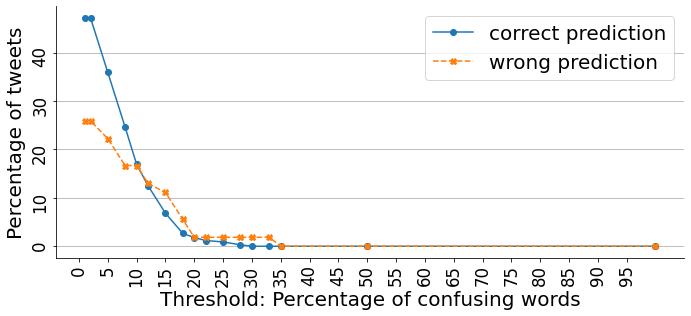

In [1261]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(10, 4.8))


plt.plot(cp_threshold_percentage_df['threshold'].tolist(),
         cp_threshold_percentage_df['percentage'].tolist(),
         label = "correct prediction",  marker='o')
plt.plot(wp_threshold_percentage_df['threshold'].tolist(),
         wp_threshold_percentage_df['percentage'].tolist(),
         label = "wrong prediction",  marker='X', linestyle='dashed')

plt.xticks(rotation = 0)
plt.xticks(np.arange(0, 100, 5.0))
plt.grid(axis='y')
plt.xlabel('Threshold: Percentage of confusing words')
plt.ylabel('Percentage of tweets')
ax.set_axisbelow(True)
ax.tick_params(labelsize='small', rotation=90)
ax.yaxis.labelpad = 5
plt.legend(loc='upper right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('../afd-green-threshold.pdf')
# plt.savefig('../fdp-linke-threshold.pdf')

In [1265]:
# pd.DataFrame([wp_threshold_percentage_df['threshold'],
#              wp_threshold_percentage_df['percentage'] - cp_threshold_percentage_df['percentage']])
wp = wp_threshold_percentage_df[(wp_threshold_percentage_df['threshold']>=10) & (wp_threshold_percentage_df['threshold']<=35)]
cp = cp_threshold_percentage_df[(cp_threshold_percentage_df['threshold']>=10) & (cp_threshold_percentage_df['threshold']<=35)]

np.mean(wp['percentage'] - cp['percentage'])



1.3073364705412176

## Top n% has a token receiving highest attention? Percentage of them satisfying the condition

In [1227]:
import math
def get_n_percent_tokens_with_highest_positive_difference(row, n_percent):
    diffs = row['tf_idf_diffs']
    diff_values = []
    tokens = []
    if isinstance(diffs, str):
        diffs = ast.literal_eval(diffs)
    n_tokens_to_be_returned = math.ceil((n_percent/100.0)*len(diffs))
    for e in diffs:
        diff_values.append(e['diff'])
        tokens.append(e['token'])
    sorted_args = np.argsort(diff_values)
    tokens = [tokens[i] for i in list(sorted_args[:n_tokens_to_be_returned])]
    if len(tokens) == 0:
        return None
    else:
        return tokens
    
def get_the_token_with_highest_attention(row, is_word=True):
    attention_scores = row['attention_scores']
    if isinstance(attention_scores, str):
        attention_scores = ast.literal_eval(attention_scores)
    tokens = row['tokens']
    if isinstance(tokens, str):
        tokens = ast.literal_eval(tokens)
    highest = 0
    token = None
    for i,a in enumerate(attention_scores):
        if a != '':
            a = float(a)
            if is_word:
                if (a > highest) & (len(tokens[i])>0):
                    highest = a
                    token = tokens[i]
            elif (a > highest):
                highest = a
                token = tokens[i]
    print(token)
    return token

def does_top_token_contain_high_attention_word(row):
    top_k_positive_diff_tokens = row['top_k_tokens']
    highest_attention_token = row['highest_attention_token']
    if highest_attention_token in top_k_positive_diff_tokens:
        return True
    else:
        return False
    
def strip(row):
    text = row['text']
    return text.strip()

In [1228]:
test_tfidf_diffs = pd.read_csv('../results/error_analysis/ea_afd-green.csv')
test_tfidf_diffs['text'] = test_tfidf_diffs.apply(strip, axis=1)
test_tfidf_diffs = test_tfidf_diffs.replace('', np.nan, regex=True)
test_tfidf_diffs = test_tfidf_diffs.dropna()
attentions = pd.read_csv('../results/error_analysisafd-green-test-data-attentions.csv')

In [1218]:
test_tfidf_diffs = pd.read_csv('../results/error_analysis/ea_fdp_linke.csv')
test_tfidf_diffs['text'] = test_tfidf_diffs.apply(strip, axis=1)
test_tfidf_diffs = test_tfidf_diffs.replace('', np.nan, regex=True)
test_tfidf_diffs = test_tfidf_diffs.dropna()
attentions = pd.read_csv('../results/error_analysisfdp_linke-test-data-attentions.csv')

In [1229]:
attentions['highest_attention_token'] = attentions.apply(get_the_token_with_highest_attention, is_word=True, axis=1)
test_tfidf_diffs['highest_attention_token'] = attentions['highest_attention_token'].tolist()
wp = test_tfidf_diffs[test_tfidf_diffs['prediction']!=test_tfidf_diffs['labels']]
cp = test_tfidf_diffs[test_tfidf_diffs['prediction']==test_tfidf_diffs['labels']]

stats = []
for n_percent in [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]:
    wp['top_k_tokens'] = wp.apply(get_n_percent_tokens_with_highest_positive_difference, n_percent=n_percent, axis=1)
    wp['contains'] = wp.apply(does_top_token_contain_high_attention_word, axis=1)
    percentage = (wp[wp['contains']].shape[0]/float(wp.shape[0]))*100
    stats.append({'top_k_percentage':n_percent, 'percentage': percentage})
    print(percentage)
stats_df_wp = pd.DataFrame(stats)
cp = test_tfidf_diffs[test_tfidf_diffs['prediction']==test_tfidf_diffs['labels']]

stats = []
for n_percent in [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]:
    cp['top_k_tokens'] = cp.apply(get_n_percent_tokens_with_highest_positive_difference, n_percent=n_percent, axis=1)
    cp['contains'] = cp.apply(does_top_token_contain_high_attention_word, axis=1)
    percentage = (cp[cp['contains']].shape[0]/float(cp.shape[0]))*100
    stats.append({'top_k_percentage':n_percent, 'percentage': percentage})
    print(percentage)
stats_df_cp = pd.DataFrame(stats)

Verkehrswende
chen
InternationalerTagdesBieres
Ehefueralle
BerlinDirekt
her
verwunderlich
DarumGrün
KrimAnnexion
DarumGRÜN
Pflegestreik
UnsereZeitLäuft
Ehrensold
begeht
Kohleausstieg
herunterkamen
SolarOffensive
darumGRÜN
Grüße
Seenotrettung
DarumGrün
KatrinonTour
zukunftwirdausmutgemacht
btw17
KatrinonTour
ZukunftWirdAusMutGemacht
wirds
DarumGruen
Katrin
RefugeesWelcome
DarumGruen
Bedürftige
birthday
Klimapavillion
Herausragend
ZukunftWirdAusMutGemacht
Hetze
seidieroteLinie
sympathisch
genervt
Verbrennungsmotors
zukunftsfähig
Pushbacks
btw17
Glasfasernetzes
DarumGruen
Autokraten
RefugeesWelcome
Servicetweet
DarumGruen
Zündkerze
Nachrüstprogramm
freedeniz
Investitionsoffensive
Seenotrettung
tvduell
tvDuell
Einwanderungsgesellschaft
OswaldElektromotoren
WELTWahlchat
Lackmustest
retweeten
verHANDELbar
GET
DarumGruen
Dobrindt
Katrin
darumGRÜN
dabei
Tageshöchstzeiten
DarumGruen
DarumGruen
Wir
ZukunftWirdAusMutGemacht
darumGRÜN
DarumGrün
DarumGrün
DarumGruen
provozieren
darumGRÜN
btw17
frei

/tmp/ipykernel_18417/2789203678.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wp['top_k_tokens'] = wp.apply(get_n_percent_tokens_with_highest_positive_difference, n_percent=n_percent, axis=1)
/tmp/ipykernel_18417/2789203678.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wp['contains'] = wp.apply(does_top_token_contain_high_attention_word, axis=1)


6.0606060606060606
9.090909090909092
12.121212121212121
12.121212121212121
15.151515151515152
18.181818181818183
27.27272727272727
27.27272727272727
30.303030303030305
33.33333333333333
39.39393939393939
39.39393939393939
42.42424242424242
42.42424242424242
42.42424242424242
42.42424242424242
2.512562814070352


/tmp/ipykernel_18417/2789203678.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp['top_k_tokens'] = cp.apply(get_n_percent_tokens_with_highest_positive_difference, n_percent=n_percent, axis=1)
/tmp/ipykernel_18417/2789203678.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp['contains'] = cp.apply(does_top_token_contain_high_attention_word, axis=1)


3.7688442211055273
4.773869346733668
6.532663316582915
7.035175879396985
7.035175879396985
7.788944723618091
8.291457286432161
10.804020100502512
10.804020100502512
12.060301507537687
12.311557788944723
14.824120603015075
16.582914572864322
17.33668341708543
18.341708542713565
19.34673366834171
20.603015075376884
23.115577889447238
23.115577889447238


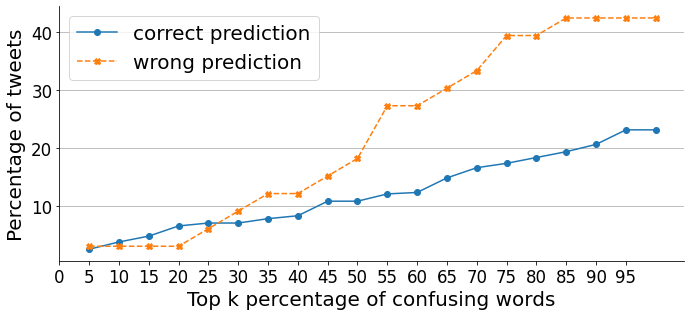

In [1230]:
fig, ax = plt.subplots(figsize=(10, 4.8))
plt.plot(stats_df_cp['top_k_percentage'].tolist(),
         stats_df_cp['percentage'].tolist(),
         label = "correct prediction",  marker='o')
plt.plot(stats_df_wp['top_k_percentage'].tolist(),
         stats_df_wp['percentage'].tolist(),
         label = "wrong prediction",  marker='X', linestyle='dashed')


plt.xticks(rotation = 0)
plt.xticks(np.arange(0, 100, 5.0))
plt.grid(axis='y')
plt.xlabel('Top k percentage of confusing words')
plt.ylabel('Percentage of tweets')
ax.set_axisbelow(True)
ax.tick_params(labelsize='small')
ax.yaxis.labelpad = 5
plt.legend(loc='upper left')
# plt.legend(loc='lower right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('../afd-green-attention.pdf')
# plt.savefig('../fdp-linke-attention.pdf')

In [1232]:
pd.DataFrame([stats_df_cp['top_k_percentage'].tolist(),stats_df_cp['percentage'].tolist(),stats_df_wp['percentage'].tolist()])
# np.mean(stats_df_wp['percentage']-stats_df_cp['percentage'])

0                    1                    2                    3                    4                    5                    6                    7                    8                    9                    10                   11                   12                   13                   14                   15                   16                   17                   18                   19
0    5.000000000000000   10.000000000000000   15.000000000000000   20.000000000000000   25.000000000000000   30.000000000000000   35.000000000000000   40.000000000000000   45.000000000000000   50.000000000000000   55.000000000000000   60.000000000000000   65.000000000000000   70.000000000000000   75.000000000000000   80.000000000000000   85.000000000000000   90.000000000000000   95.000000000000000  100.000000000000000
1    2.512562814070352    3.768844221105527    4.773869346733668    6.532663316582915    7.035175879396985    7.035175879396985    7.788944723618091    8.291457286432161   10.804020100502512   10.804020100502512   12.060301507537687   12.311557788944723   14.824120603015075   16.582914572864322   17.336683417085428   18.341708542713565   19.346733668341709   20.603015075376884   23.115577889447238   23.115577889447238
2    3.030303030303030    3.030303030303030    3.030303030303030    3.030303030303030    6.060606060606061    9.090909090909092   12.121212121212121   12.121212121212121   15.151515151515152   18.181818181818183   27.272727272727270   27.272727272727270   30.303030303030305   33.333333333333329   39.393939393939391   39.393939393939391   42.424242424242422   42.424242424242422   42.424242424242422   42.424242424242422

In [1233]:
42.42-23.11

19.310000000000002

# Repeating the analysis for PMI based scoring

In [1235]:
import ast
import pandas as pd
def get_percentage_positive_diff_tokens(row):
    diffs = row['pmi_diffs']
    if isinstance(diffs, str):
        diffs = ast.literal_eval(diffs)
    count = 0
    for e in diffs:
        if e['diff']>0:
            count = count + 1
    if count == 0: 
        return 0
    percentage = (count/float(len(diffs)))*100
    return percentage

def get_token_with_highest_positive_difference(row):
    diffs = row['pmi_diffs']
    if isinstance(diffs, str):
        diffs = ast.literal_eval(diffs)
    highest = 0
    token = ''
    for e in diffs:
        if e['diff']> highest:
            highest = e['diff']
            token = e['token']
    if token == '':
        return None
    else:
        return token
    
    
def get_token_with_highest_attention(row):
    token = row['highest_positive_token']
    attention_scores = row['attention_scores']
    if isinstance(attention_scores, str):
        attention_scores = ast.literal_eval(attention_scores)
    tokens = row['tokens']
    is_highest = False
    highest = 0
    if isinstance(tokens, str):
        tokens = ast.literal_eval(tokens)
    try:
        token_index = tokens.index(token)
        sum_ = 0
        for i in attention_scores:
            if i !='':
                sum_ = sum_ + float(i)
                if float(i) > highest:
                    highest = float(i)
                    is_highest = True
                else:
                    highest = float(i)
                    is_highest = False
        row['percentage_attention'] = float(attention_scores[token_index])/sum
        row['is_highest_attention'] = is_highest
        return row
    except ValueError as e:
        row['percentage_attention'] = None
        row['is_highest_attention'] = None
        return row

    import math
    
def get_n_percent_tokens_with_highest_positive_difference(row, n_percent):
    diffs = row['pmi_diffs']
    diff_values = []
    tokens = []
    if isinstance(diffs, str):
        diffs = ast.literal_eval(diffs)
    n_tokens_to_be_returned = math.ceil((n_percent/100.0)*len(diffs))
    for e in diffs:
        diff_values.append(e['diff'])
        tokens.append(e['token'])
    sorted_args = np.argsort(diff_values)
    tokens = [tokens[i] for i in list(sorted_args[:n_tokens_to_be_returned])]
    if len(tokens) == 0:
        return None
    else:
        return tokens
    
def get_the_token_with_highest_attention(row, is_word=True):
    attention_scores = row['attention_scores']
    if isinstance(attention_scores, str):
        attention_scores = ast.literal_eval(attention_scores)
    tokens = row['tokens']
    if isinstance(tokens, str):
        tokens = ast.literal_eval(tokens)
    highest = 0
    token = None
    for i,a in enumerate(attention_scores):
        if a != '':
            a = float(a)
            if is_word:
                if (a > highest) & (len(tokens[i])>0):
                    highest = a
                    token = tokens[i]
            elif (a > highest):
                highest = a
                token = tokens[i]
    print(token)
    return token

def does_top_token_contain_high_attention_word(row):
    top_k_positive_diff_tokens = row['top_k_tokens']
    highest_attention_token = row['highest_attention_token']
    if highest_attention_token in top_k_positive_diff_tokens:
        return True
    else:
        return False
    
def strip(row):
    text = row['text']
    return text.strip()

In [1246]:
test_tfidf_diffs = pd.read_csv('../results/error_analysis/ea_pmifdp_linke.csv')
def strip(row):
    text = row['text']
    return text.strip()
test_tfidf_diffs['text'] = test_tfidf_diffs.apply(strip, axis=1)
test_tfidf_diffs = test_tfidf_diffs.replace('', np.nan, regex=True)
test_tfidf_diffs = test_tfidf_diffs.dropna()
attentions = pd.read_csv('../results/error_analysisfdp_linke-test-data-attentions.csv')
test_tfidf_diffs['percentage_positive_diffs'] = test_tfidf_diffs.apply(get_percentage_positive_diff_tokens, axis=1)

In [1236]:
test_tfidf_diffs = pd.read_csv('../results/error_analysis/ea_pmiafd-green.csv')
def strip(row):
    text = row['text']
    return text.strip()
test_tfidf_diffs['text'] = test_tfidf_diffs.apply(strip, axis=1)
test_tfidf_diffs = test_tfidf_diffs.replace('', np.nan, regex=True)
test_tfidf_diffs = test_tfidf_diffs.dropna()
attentions = pd.read_csv('../results/error_analysisafd-green-test-data-attentions.csv')
test_tfidf_diffs['percentage_positive_diffs'] = test_tfidf_diffs.apply(get_percentage_positive_diff_tokens, axis=1)

In [1247]:
threshold_percentage = []
wp = test_tfidf_diffs[test_tfidf_diffs['prediction']!=test_tfidf_diffs['labels']]
for threshold in [1,2,5,8,10,12,15,18,20,22,25,28,30,33,35,50,100]:
    sel = wp[wp['percentage_positive_diffs'] >= threshold]
    threshold_percentage.append({'threshold': threshold, 'percentage':(sel.shape[0]/float(wp.shape[0]))*100})
    
wp_threshold_percentage_df = pd.DataFrame(threshold_percentage)
threshold_percentage = []
cp = test_tfidf_diffs[test_tfidf_diffs['prediction']==test_tfidf_diffs['labels']]
for threshold in [1,2,5,8,10,12,15,18,20,22,25,28,30,33,35,50,100]:
    sel = cp[cp['percentage_positive_diffs'] >= threshold]
    threshold_percentage.append({'threshold': threshold, 'percentage':(sel.shape[0]/float(cp.shape[0]))*100})
cp_threshold_percentage_df = pd.DataFrame(threshold_percentage)


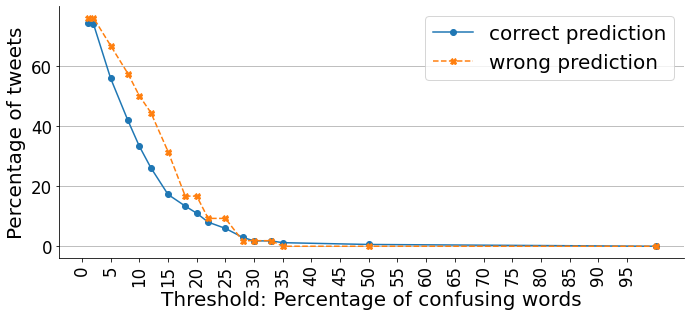

In [1248]:
fig, ax = plt.subplots(figsize=(10, 4.8))

plt.plot(cp_threshold_percentage_df['threshold'].tolist(),
         cp_threshold_percentage_df['percentage'].tolist(),
         label = "correct prediction",  marker='o')
plt.plot(wp_threshold_percentage_df['threshold'].tolist(),
         wp_threshold_percentage_df['percentage'].tolist(),
         label = "wrong prediction",  marker='X', linestyle='dashed')


plt.xticks(rotation = 90)
plt.xticks(np.arange(0, 100, 5.0))
plt.grid(axis='y')
plt.xlabel('Threshold: Percentage of confusing words')
plt.ylabel('Percentage of tweets')
ax.set_axisbelow(True)
ax.tick_params(labelsize='small')
ax.yaxis.labelpad = 5
plt.legend(loc='upper right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig('../afd-green-pmi-threshold.pdf')
# plt.savefig('../fdp-linke-pmi-threshold.pdf')  

In [1249]:
pd.DataFrame([wp_threshold_percentage_df['threshold'],
             wp_threshold_percentage_df['percentage'] - cp_threshold_percentage_df['percentage']])
np.mean(wp_threshold_percentage_df['percentage'] - cp_threshold_percentage_df['percentage'])

5.318619369937225

In [1250]:
attentions['highest_attention_token'] = attentions.apply(get_the_token_with_highest_attention, is_word=True, axis=1)
test_tfidf_diffs['highest_attention_token'] = attentions['highest_attention_token'].tolist()
wp = test_tfidf_diffs[test_tfidf_diffs['prediction']!=test_tfidf_diffs['labels']]
cp = test_tfidf_diffs[test_tfidf_diffs['prediction']==test_tfidf_diffs['labels']]

stats = []
for n_percent in [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]:
    wp['top_k_tokens'] = wp.apply(get_n_percent_tokens_with_highest_positive_difference, n_percent=n_percent, axis=1)
    wp['contains'] = wp.apply(does_top_token_contain_high_attention_word, axis=1)
    percentage = (wp[wp['contains']].shape[0]/float(wp.shape[0]))*100
    stats.append({'top_k_percentage':n_percent, 'percentage': percentage})
    print(percentage)
stats_df_wp = pd.DataFrame(stats)
cp = test_tfidf_diffs[test_tfidf_diffs['prediction']==test_tfidf_diffs['labels']]

stats = []
for n_percent in [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]:
    cp['top_k_tokens'] = cp.apply(get_n_percent_tokens_with_highest_positive_difference, n_percent=n_percent, axis=1)
    cp['contains'] = cp.apply(does_top_token_contain_high_attention_word, axis=1)
    percentage = (cp[cp['contains']].shape[0]/float(cp.shape[0]))*100
    stats.append({'top_k_percentage':n_percent, 'percentage': percentage})
    print(percentage)
stats_df_cp = pd.DataFrame(stats)

Updates
Pilzpfanne
Vorbeitrittshilfen
[UNK]
Militärbasen
Dieselbetrug
ACK
Ehrensold
Aufrüstung
Dieselgate
sondierte
Mohring
Geschrei
Finanztabu
?
Pjöngjang
btw17
synchronisieren
Reset
OBs
Gemeindemodell
Charlottesville
btw17
Feminismus
Deutschlandfunk
Landtagsdebatte
Dieselskandal
berlindirekt
berlindirekt
btw17
digitallinks
ueberzeugtuns
DieselgateInfo
hinzuweisen
Seenotrettern
ElternBeiträge
ElternBeiträge
Sonneberg
NULL
odVormundschaftlich
Hebammenverband
Kumpanei
Splitting
Obermoralapostel
rentendemo
Funklochmelder
Kipping
sommerinterview
Minijobs
Scholzomat
annewill
allgemeinverbindlich
btw17
Armutsbekämpfung
prekären
BTW17
Eskalation
WahlOMat
abgeschlagen
wahl2017
btw17
aufkrempeln
duverdienstmehr
Pöbeleien
TVDuell
TVDuell
fadenscheinige
Kreisreform
Verfolgen
BTW17
Arbeitstermin
LINKE
besorgniserregend
Wurst
gepudert
gegrüßt
ausspielen
BTW17
Anabolika
Genussland
ALLE
anzudichten
dielinke
wahlarena
Dresdenwirdrot
aussagekräftig
LINKE
LINKE
Friedenspolitik
Kneipenwahlkampf
LINKE
bt

/tmp/ipykernel_18417/2789203678.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wp['top_k_tokens'] = wp.apply(get_n_percent_tokens_with_highest_positive_difference, n_percent=n_percent, axis=1)
/tmp/ipykernel_18417/2789203678.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wp['contains'] = wp.apply(does_top_token_contain_high_attention_word, axis=1)


11.11111111111111
12.962962962962962
16.666666666666664
20.37037037037037
20.37037037037037
22.22222222222222
22.22222222222222
24.074074074074073
24.074074074074073
24.074074074074073
24.074074074074073
24.074074074074073
25.925925925925924
25.925925925925924
25.925925925925924
25.925925925925924
25.925925925925924
25.925925925925924
25.925925925925924
27.77777777777778


/tmp/ipykernel_18417/2789203678.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp['top_k_tokens'] = cp.apply(get_n_percent_tokens_with_highest_positive_difference, n_percent=n_percent, axis=1)
/tmp/ipykernel_18417/2789203678.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp['contains'] = cp.apply(does_top_token_contain_high_attention_word, axis=1)


5.934718100890208
6.231454005934718
8.30860534124629
10.682492581602373
14.243323442136498
16.320474777448073
20.77151335311573
22.255192878338278
22.8486646884273
24.03560830860534
25.519287833827892
25.519287833827892
25.816023738872403
26.112759643916917
26.112759643916917
26.112759643916917
26.112759643916917
26.409495548961427
27.596439169139465
27.89317507418398


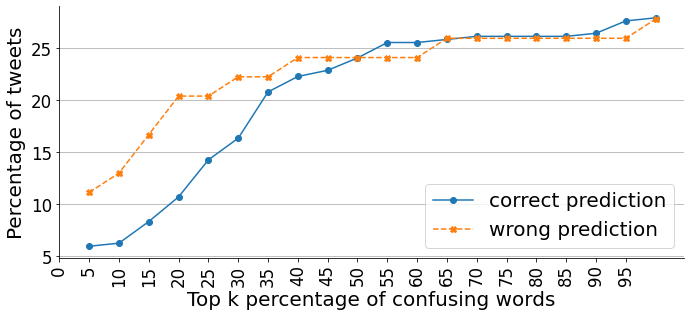

In [1251]:
fig, ax = plt.subplots(figsize=(10, 4.8))
plt.plot(stats_df_cp['top_k_percentage'].tolist(),
         stats_df_cp['percentage'].tolist(),
         label = "correct prediction",  marker='o')
plt.plot(stats_df_wp['top_k_percentage'].tolist(),
         stats_df_wp['percentage'].tolist(),
         label = "wrong prediction",  marker='X', linestyle='dashed')


plt.xticks(rotation = 90)
plt.xticks(np.arange(0, 100, 5.0))
plt.grid(axis='y')
plt.xlabel('Top k percentage of confusing words')
plt.ylabel('Percentage of tweets')
ax.set_axisbelow(True)
ax.tick_params(labelsize='small')
ax.yaxis.labelpad = 5
plt.legend(loc='lower right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('../fdp-linke-pmi-atention.pdf')
# plt.savefig('../afd-green-pmi-atention.pdf')

In [1252]:
pd.DataFrame([stats_df_cp['top_k_percentage'].tolist(),stats_df_cp['percentage'].tolist(),stats_df_wp['percentage'].tolist()])
# np.mean(stats_df_wp['percentage']-stats_df_cp['percentage'].tolist())


0                    1                    2                    3                    4                    5                    6                    7                    8                    9                    10                   11                   12                   13                   14                   15                   16                   17                   18                   19
0    5.000000000000000   10.000000000000000   15.000000000000000   20.000000000000000   25.000000000000000   30.000000000000000   35.000000000000000   40.000000000000000   45.000000000000000   50.000000000000000   55.000000000000000   60.000000000000000   65.000000000000000   70.000000000000000   75.000000000000000   80.000000000000000   85.000000000000000   90.000000000000000   95.000000000000000  100.000000000000000
1    5.934718100890208    6.231454005934718    8.308605341246290   10.682492581602373   14.243323442136498   16.320474777448073   20.771513353115729   22.255192878338278   22.848664688427299   24.035608308605340   25.519287833827892   25.519287833827892   25.816023738872403   26.112759643916917   26.112759643916917   26.112759643916917   26.112759643916917   26.409495548961427   27.596439169139465   27.893175074183979
2   11.111111111111111   12.962962962962962   16.666666666666664   20.370370370370370   20.370370370370370   22.222222222222221   22.222222222222221   24.074074074074073   24.074074074074073   24.074074074074073   24.074074074074073   24.074074074074073   25.925925925925924   25.925925925925924   25.925925925925924   25.925925925925924   25.925925925925924   25.925925925925924   25.925925925925924   27.777777777777779

In [1253]:
np.mean(stats_df_wp['percentage'] - stats_df_cp['percentage'])

2.0359380151665

In [1245]:
42.42-23.11

19.310000000000002